In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import backward
from coolmom import SGD

import numpy as np
import pickle
import os
from sklearn.utils import shuffle
from tqdm import tqdm
import ipdb

import Utils.util as util

np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

In [20]:
# CRASH_fname = 'CRASH_FE_filtered_subsampled_fmriADJ.pkl'

# with open(CRASH_fname, 'rb') as handle:
#     F_t, adj_mx, adj_mx_idx, _input, _gt, coeffs, \
#     inv_mapping, region_assignment, nTrain, nValid, \
#     nTest, scaler_in, scaler_out = pickle.load(handle)
    
CRASH_fname = 'CRASH_Fonly.pkl'
with open(CRASH_fname, 'rb') as handle:
    F_t, adj_mx, adj_mx_idx, _input, _gt, nTrain, \
    nValid, nTest, scaler_in, scaler_out = pickle.load(handle)


### helper functions to test

In [3]:
def weighted_mse(preds, labels, null_val=np.nan):
    # assign more weights to further away points (preds:[16, 1, 10])
    num_t = preds.shape[2]
    wts = (torch.arange(num_t) + 1.0) / (torch.arange(num_t) + 1.0).sum()

    loss = (preds-labels)**2
    loss = torch.mean(loss, [0,1])

    wts = wts.to(loss.device)
    loss = loss * wts
    
    return torch.mean(loss)

def clipped_repulsion(preds):
    preds = abs(preds)
    
    preds[preds < 1e-3] = 1e-3
    loss = 1 / (abs(preds)**2)
    return torch.mean(loss)

## Testing temporal conv-deconv: only using one node's value across time

(11712, 1, 10) (11712, 1, 10)


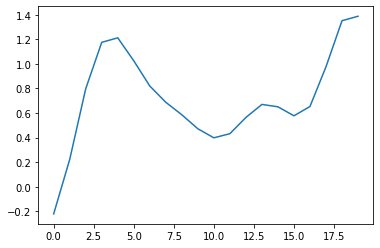

In [53]:
device = 'cuda:0'
# prep data
x = _input[...,0][:,None,:]
# y = x
y = _gt[...,0][:,None,:]
print(x.shape, y.shape)

# plt.plot(x[0,0])
# plt.plot(y[0,0])
plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)


In [63]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
    pad = (kernel_size - 1) * dilation
    return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

# def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs): 
#     ## only pad left (??? pytorch doesn't support)
#     pad = (kernel_size - 1) * dilation
#     return nn.Conv1d(in_channels, out_channels, kernel_size, padding=(pad,0), dilation=dilation, **kwargs)


# tcn & de-tcn model
class tmodel(nn.Module): # for model testing, f in, same f out
    def __init__(self, device='cuda:0', dropout=0.3, in_dim=1,
                residual_channels=32, dilation_channels=32, skip_channels=256,
                end_channels=64, kernel_size=2, blocks=4, layers=2):
        super(tmodel, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.device = device

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()

        self.start_conv = nn.Conv1d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=1)

        receptive_field = 1
        multi_factor = 2
        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))
                self.gate_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=residual_channels,kernel_size=1))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=skip_channels,kernel_size=1))
                self.bn.append(nn.BatchNorm1d(residual_channels))

                new_dilation *= multi_factor
                receptive_field += additional_scope
                additional_scope *= multi_factor


#         ## temporal transConv (de-tcn)
#         convTransK = 2
#         convTransD = 1
#         upScale = 2

#         self.end_module_conv = nn.ModuleList()
#         self.end_module_up = nn.ModuleList()
#         # for b in range(blocks):
#         #     for l in range(layers):
#         for i in range(3):
#             self.end_module_up.append(nn.Upsample(scale_factor=upScale))
#             self.end_module_conv.append(nn.ConvTranspose1d(in_channels=skip_channels, out_channels=residual_channels, 
#                            kernel_size=convTransK, dilation=convTransD))
#         self.end_mlp = nn.Sequential(
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=128, out_channels=16,
#                       kernel_size=1, bias=True),
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=16, out_channels=1,
#                       kernel_size=1, bias=True)
#             )
        self.end_conv_1 = nn.Conv1d(skip_channels, end_channels, 1, bias=True)
        self.end_conv_2 = nn.Conv1d(end_channels, 10, 1, bias=True)
        self.end_conv_3 = nn.Conv1d(10, 1, 1, bias=True)
        
        self.receptive_field = receptive_field

    def forward(self, input, viz=False):
        # inputs: [batch_size, 1, in_len]
        ### deal with supports
        # print(self.receptive_field)
#         in_len = input.size(-1)
#         if in_len<self.receptive_field:
#             x = nn.functional.pad(input,(self.receptive_field-in_len,0))
#         else:
#             x = input
        x = input
        x = self.start_conv(x)

        if viz: # x.shape [16, 32, 15]
            ### plot features on different channels representing the same node fmri signal
            for j in range(x.shape[1]):
                plt.plot(x.detach().cpu().numpy()[0,j,:])
            plt.show()

        skip = 0

        # WaveNet layers
        for i in range(self.blocks * self.layers):
            # print(i, x.shape)
            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + --> *input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + -------------> *skip*

            #(dilation, init_dilation) = self.dilations[i]

            #residual = dilation_func(x, dilation, init_dilation, i)
            residual = x #[batch_size, residual_dim, 80, 16]

            # dilated convolution
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter[:, :, :-self.filter_convs[i].padding[0]])
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate[:, :, :-self.gate_convs[i].padding[0]])
            x = filter * gate
#             print(x.shape)
            if i % self.layers == self.layers-1:
                x = F.max_pool1d(x,2)
            # parametrized skip connection
            s = x
            s = self.skip_convs[i](s)
            try:
                if s.size(-1)*2 == skip.size(-1):
                    skip = F.max_pool1d(skip,2)
                else:
                    skip = skip[:, :,  -s.size(-1):]
            except:
                skip = 0
            skip = s + skip
            
            x = self.residual_convs[i](x)
            
#             print(residual.shape, x.shape)
            x = x + residual[:, :, -x.size(-1):]
            # x = torch.cat([x, residual[:, :, :, -x.size(3):], t_rep], axis=1)
            x = self.bn[i](x) # comment off for overfitting
            
        # del residual, x
        # skip: [batch_size, hidden_dim, num_nodes, 1]

        # ### test: adding noise to hidden rep
        # skip = skip + torch.normal(torch.zeros_like(skip), 0.1*skip.std()*torch.ones_like(skip))
        # ###
        # x = self.end_module(skip)
        # if viz: # x.shape [16, 512, 200, 1]
        #     # (results look similar) each node's h-D (h being #hidden dim) feature
        #     for j in range(10):
        #         plt.plot(x.detach().cpu().numpy()[0,:,j,0])
        #     plt.show()
        #     # plot each channel's value (on all nodes)
        #     for j in range(10): 
        #         plt.plot(x.detach().cpu().numpy()[0,j,:,0])
        #     plt.show()
        
        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
#         x = self.end_conv_2(x).transpose(1,2)
        
        # output a single value
        x = F.relu(self.end_conv_2(x))   
        x = self.end_conv_3(x)
        
#         for i in range(3):#range(self.blocks * self.layers):       
#             x = self.end_module_up[i](x)
#             x = F.relu(self.end_module_conv[i](x))
        
#         x = self.end_mlp(x)
#         # x = self.end_mlp_f(x.transpose(1,3))
        return x

model = tmodel(blocks=3, layers=2).to(device)
print(model)
model_name = "garage/exp_t_pred1step_mse.pth" # for loading pretrained model and saving trained ones

tmodel(
  (filter_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (3): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (5): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
  )
  (gate_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (3): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (5): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
  )
  (resid

In [35]:
# load pretrained model
if os.path.isfile(model_name):
    # finetune
    pretrained_dict = torch.load(model_name)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)

In [64]:
# training & validation
lrate = 3e-4
wdecay = 4e-3 #TODO: increase
repulsion_w = 1e-4

num_epoch = 500
batch_size = 64

print(nTrain, nValid, nTest)
xTrain = x[:nTrain]
xValid = x[nTrain:nTrain+nValid]

yTrain = y[:nTrain]
yValid = y[nTrain:nTrain+nValid]

if not os.path.isfile(model_name):
    train_loss = []
    val_loss = []
min_val_loss = 1000
obj = nn.MSELoss()
for e in range(num_epoch):
#     if e%50 == 0 and e>0:
#         lrate = lrate * 0.8
#     optimizer = SGD(model.parameters(), lr=lrate, weight_decay=wdecay, momentum=0.9, beta=1e-2)
    optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)
    
    # train part
    model.train()
    # shuffle
    xTrain, yTrain = shuffle(xTrain, yTrain)
    cur_loss = []
    for i in tqdm(range(nTrain//batch_size)):
        batch_in = xTrain[i*batch_size:(i+1)*batch_size]
        batch_gt = yTrain[i*batch_size:(i+1)*batch_size][:,:,0:1]
        
        out = model(batch_in)
        loss = obj(out, batch_gt) #+ repulsion_w*clipped_repulsion(out)
        cur_loss.append(loss.item())
        
#         if i%150 == 0:
#             print(i, 'loss', loss.item(), 'mape', util.masked_mape(out, batch_gt,0).item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss.append(np.mean(cur_loss))
    print('epoch',e, 'train loss', np.mean(cur_loss))
    # validate each epoch
    model.eval()
    with torch.no_grad():
        out = model(xValid)
    loss = obj(out, yValid[:,:,0:1])
#     loss = obj(out, yValid) #+ repulsion_w*clipped_repulsion(out)
    val_loss.append(loss.item())
    if loss.item() < min_val_loss:
        min_val_loss = loss.item()
        torch.save(model.state_dict(), model_name)
    print('val loss', loss.item(), 'mape', util.masked_mape(out, yValid,0).item())


  5%|▍         | 6/128 [00:00<00:02, 49.60it/s]

8198 1757 1757


  5%|▍         | 6/128 [00:00<00:02, 50.27it/s]

epoch 0 train loss 0.22259659043629654
val loss 0.04391806200146675 mape 7.534990310668945


  4%|▍         | 5/128 [00:00<00:02, 48.14it/s]

epoch 1 train loss 0.041992416634457186
val loss 0.03197725489735603 mape 6.64809513092041


  4%|▍         | 5/128 [00:00<00:02, 48.99it/s]

epoch 2 train loss 0.027899412016267888
val loss 0.01817246899008751 mape 4.093479633331299


  4%|▍         | 5/128 [00:00<00:02, 48.75it/s]

epoch 3 train loss 0.021881205124373082
val loss 0.01716831512749195 mape 5.953685283660889


  4%|▍         | 5/128 [00:00<00:02, 49.81it/s]

epoch 4 train loss 0.016371133770007873
val loss 0.010182141326367855 mape 4.6591315269470215


  5%|▍         | 6/128 [00:00<00:02, 50.12it/s]

epoch 5 train loss 0.01627849612850696
val loss 0.008619369938969612 mape 4.580525875091553


  5%|▍         | 6/128 [00:00<00:02, 49.86it/s]

epoch 6 train loss 0.014232159624953056
val loss 0.007140600122511387 mape 4.816939830780029


  5%|▍         | 6/128 [00:00<00:02, 50.69it/s]

epoch 7 train loss 0.013881553284591064
val loss 0.014766297303140163 mape 3.3789565563201904


  4%|▍         | 5/128 [00:00<00:02, 49.80it/s]

epoch 8 train loss 0.013443953863315983
val loss 0.0072923991829156876 mape 4.677306652069092


  5%|▍         | 6/128 [00:00<00:02, 50.82it/s]

epoch 9 train loss 0.012843986833104282
val loss 0.008129803463816643 mape 3.937753915786743


  4%|▍         | 5/128 [00:00<00:02, 49.16it/s]

epoch 10 train loss 0.014039375600987114
val loss 0.0074213058687746525 mape 4.931251049041748


  4%|▍         | 5/128 [00:00<00:02, 49.55it/s]

epoch 11 train loss 0.011305797925160732
val loss 0.007039832882583141 mape 5.037226676940918


  4%|▍         | 5/128 [00:00<00:02, 49.26it/s]

epoch 12 train loss 0.010589383149635978
val loss 0.007153629790991545 mape 4.658494472503662


  4%|▍         | 5/128 [00:00<00:02, 49.48it/s]

epoch 13 train loss 0.011031146897948929
val loss 0.005043155513703823 mape 4.946445465087891


  5%|▍         | 6/128 [00:00<00:02, 54.21it/s]

epoch 14 train loss 0.009860182944976259
val loss 0.005587471183389425 mape 4.757388114929199


  5%|▍         | 6/128 [00:00<00:02, 56.21it/s]

epoch 15 train loss 0.012000392947811633
val loss 0.0058127338998019695 mape 4.267998695373535


  4%|▍         | 5/128 [00:00<00:02, 49.76it/s]

epoch 16 train loss 0.010650267913661082
val loss 0.00826287642121315 mape 4.1656999588012695


  4%|▍         | 5/128 [00:00<00:02, 49.49it/s]

epoch 17 train loss 0.011265075718256412
val loss 0.006149358116090298 mape 5.193233013153076


  4%|▍         | 5/128 [00:00<00:02, 49.52it/s]

epoch 18 train loss 0.010627121206198353
val loss 0.0056149461306631565 mape 4.466933250427246


  5%|▍         | 6/128 [00:00<00:02, 50.83it/s]

epoch 19 train loss 0.010555586792179383
val loss 0.006327349692583084 mape 4.413854598999023


  4%|▍         | 5/128 [00:00<00:02, 49.63it/s]

epoch 20 train loss 0.010219798943580827
val loss 0.005171660799533129 mape 5.118776798248291


  5%|▍         | 6/128 [00:00<00:02, 51.37it/s]

epoch 21 train loss 0.01191484511764429
val loss 0.005994326435029507 mape 5.113585948944092


  4%|▍         | 5/128 [00:00<00:02, 49.51it/s]

epoch 22 train loss 0.010966369685775135
val loss 0.007009940221905708 mape 5.352634429931641


  5%|▍         | 6/128 [00:00<00:02, 49.16it/s]

epoch 23 train loss 0.010021367634180933
val loss 0.006575817242264748 mape 5.414079189300537


  4%|▍         | 5/128 [00:00<00:02, 49.44it/s]

epoch 24 train loss 0.010445650712426868
val loss 0.005762544926255941 mape 5.0746026039123535


  4%|▍         | 5/128 [00:00<00:02, 49.66it/s]

epoch 25 train loss 0.00928150795516558
val loss 0.004737893119454384 mape 4.9003753662109375


  5%|▍         | 6/128 [00:00<00:02, 50.09it/s]

epoch 26 train loss 0.009697544379378087
val loss 0.0064581227488815784 mape 5.455648899078369


  4%|▍         | 5/128 [00:00<00:02, 48.79it/s]

epoch 27 train loss 0.010146362090381444
val loss 0.0043869526125490665 mape 4.899801731109619


  5%|▍         | 6/128 [00:00<00:02, 49.60it/s]

epoch 28 train loss 0.009286797374443267
val loss 0.005490932613611221 mape 5.024382591247559


  5%|▍         | 6/128 [00:00<00:02, 50.05it/s]

epoch 29 train loss 0.00937368392260396
val loss 0.005687906872481108 mape 4.983907222747803


  4%|▍         | 5/128 [00:00<00:02, 49.55it/s]

epoch 30 train loss 0.010002247803640785
val loss 0.005881078541278839 mape 5.425955772399902


  5%|▍         | 6/128 [00:00<00:02, 49.58it/s]

epoch 31 train loss 0.010158166311157402
val loss 0.004332526121288538 mape 4.8582587242126465


  5%|▍         | 6/128 [00:00<00:02, 50.16it/s]

epoch 32 train loss 0.009592694557795767
val loss 0.004403977654874325 mape 5.065683364868164


  4%|▍         | 5/128 [00:00<00:02, 49.77it/s]

epoch 33 train loss 0.010248076210700674
val loss 0.004201386123895645 mape 4.807467937469482


  5%|▍         | 6/128 [00:00<00:02, 50.72it/s]

epoch 34 train loss 0.008936814259868697
val loss 0.006171434186398983 mape 4.711996555328369


  4%|▍         | 5/128 [00:00<00:02, 49.58it/s]

epoch 35 train loss 0.011336287108861143
val loss 0.010971466079354286 mape 4.710881233215332


  4%|▍         | 5/128 [00:00<00:02, 48.26it/s]

epoch 36 train loss 0.010599030929370201
val loss 0.008239194750785828 mape 5.463886737823486


  4%|▍         | 5/128 [00:00<00:02, 49.18it/s]

epoch 37 train loss 0.007689278232646757
val loss 0.005208185408264399 mape 5.006814956665039


  4%|▍         | 5/128 [00:00<00:02, 49.73it/s]

epoch 38 train loss 0.009541433764752583
val loss 0.004683228675276041 mape 5.169960975646973


  4%|▍         | 5/128 [00:00<00:02, 49.24it/s]

epoch 39 train loss 0.010807426595420111
val loss 0.006099741905927658 mape 5.138073921203613


  5%|▍         | 6/128 [00:00<00:02, 50.70it/s]

epoch 40 train loss 0.008999922762086499
val loss 0.005184308160096407 mape 5.221658706665039


  5%|▍         | 6/128 [00:00<00:02, 52.66it/s]

epoch 41 train loss 0.009125825266892207
val loss 0.0043397932313382626 mape 4.9923858642578125


  4%|▍         | 5/128 [00:00<00:02, 49.19it/s]

epoch 42 train loss 0.010283176643497427
val loss 0.008631889708340168 mape 5.3063859939575195


  4%|▍         | 5/128 [00:00<00:02, 49.53it/s]

epoch 43 train loss 0.00947996025570319
val loss 0.0054463790729641914 mape 4.566372871398926


  5%|▍         | 6/128 [00:00<00:02, 49.53it/s]

epoch 44 train loss 0.01042522989337158
val loss 0.005246768705546856 mape 4.804112911224365


  5%|▍         | 6/128 [00:00<00:02, 51.19it/s]

epoch 45 train loss 0.008326841776579386
val loss 0.005049684550613165 mape 4.747466564178467


  5%|▍         | 6/128 [00:00<00:02, 50.19it/s]

epoch 46 train loss 0.00928499772453506
val loss 0.007287554442882538 mape 5.4042792320251465


  5%|▍         | 6/128 [00:00<00:02, 49.82it/s]

epoch 47 train loss 0.011171622736583231
val loss 0.003602782730013132 mape 4.813232898712158


  4%|▍         | 5/128 [00:00<00:02, 49.43it/s]

epoch 48 train loss 0.011199552845937433
val loss 0.004278054926544428 mape 4.63306999206543


  5%|▍         | 6/128 [00:00<00:02, 49.68it/s]

epoch 49 train loss 0.009975180721085053
val loss 0.0046181632205843925 mape 4.656810760498047


  4%|▍         | 5/128 [00:00<00:02, 49.73it/s]

epoch 50 train loss 0.008095405055428273
val loss 0.004230717197060585 mape 4.86588716506958


  4%|▍         | 5/128 [00:00<00:02, 49.32it/s]

epoch 51 train loss 0.008845562299029552
val loss 0.006150293629616499 mape 5.592247009277344


  5%|▍         | 6/128 [00:00<00:02, 49.52it/s]

epoch 52 train loss 0.009767128218300059
val loss 0.0036943925078958273 mape 4.635222434997559


  4%|▍         | 5/128 [00:00<00:02, 49.84it/s]

epoch 53 train loss 0.009589783407136565
val loss 0.0048336489126086235 mape 5.445685863494873


  5%|▍         | 6/128 [00:00<00:02, 51.25it/s]

epoch 54 train loss 0.008151387779435026
val loss 0.004977753851562738 mape 5.478482246398926


  4%|▍         | 5/128 [00:00<00:02, 49.83it/s]

epoch 55 train loss 0.009534669212371227
val loss 0.0035633668303489685 mape 4.626506328582764


  4%|▍         | 5/128 [00:00<00:02, 49.38it/s]

epoch 56 train loss 0.007456095390807604
val loss 0.0066184778697788715 mape 4.227992534637451


  4%|▍         | 5/128 [00:00<00:02, 49.51it/s]

epoch 57 train loss 0.008218127844884293
val loss 0.006061417516320944 mape 4.524800777435303


  5%|▍         | 6/128 [00:00<00:02, 51.64it/s]

epoch 58 train loss 0.00833297547615075
val loss 0.002971628215163946 mape 5.016247272491455


  5%|▍         | 6/128 [00:00<00:02, 49.29it/s]

epoch 59 train loss 0.009831875964664505
val loss 0.017539769411087036 mape 6.048661231994629


  4%|▍         | 5/128 [00:00<00:02, 49.69it/s]

epoch 60 train loss 0.008629292953628465
val loss 0.0034182672388851643 mape 4.7292160987854


  5%|▍         | 6/128 [00:00<00:02, 51.63it/s]

epoch 61 train loss 0.008696700897417031
val loss 0.005682718940079212 mape 5.169699668884277


  4%|▍         | 5/128 [00:00<00:02, 47.97it/s]

epoch 62 train loss 0.009031895069711027
val loss 0.0032960318494588137 mape 4.8423171043396


  5%|▍         | 6/128 [00:00<00:02, 49.83it/s]

epoch 63 train loss 0.008903808974537242
val loss 0.007416675332933664 mape 5.173717498779297


  5%|▍         | 6/128 [00:00<00:02, 50.68it/s]

epoch 64 train loss 0.008198905306926463
val loss 0.003646453144028783 mape 4.993167877197266


  4%|▍         | 5/128 [00:00<00:02, 49.32it/s]

epoch 65 train loss 0.009398055095516611
val loss 0.003970996476709843 mape 4.7207231521606445


  4%|▍         | 5/128 [00:00<00:02, 49.18it/s]

epoch 66 train loss 0.009633285916606837
val loss 0.004420596174895763 mape 4.876380443572998


  5%|▍         | 6/128 [00:00<00:02, 50.29it/s]

epoch 67 train loss 0.008855673459038371
val loss 0.0038785149808973074 mape 4.7387237548828125


  4%|▍         | 5/128 [00:00<00:02, 49.86it/s]

epoch 68 train loss 0.009048630055985996
val loss 0.007435838226228952 mape 4.391634464263916


  4%|▍         | 5/128 [00:00<00:02, 49.57it/s]

epoch 69 train loss 0.010221878823358566
val loss 0.003403973998501897 mape 5.399103164672852


  4%|▍         | 5/128 [00:00<00:02, 49.70it/s]

epoch 70 train loss 0.008562369215724175
val loss 0.0032316010911017656 mape 5.289299011230469


  5%|▍         | 6/128 [00:00<00:02, 51.26it/s]

epoch 71 train loss 0.008297638102703786
val loss 0.0032291708048433065 mape 5.027139663696289


  4%|▍         | 5/128 [00:00<00:02, 49.64it/s]

epoch 72 train loss 0.008389682026972878
val loss 0.00604998879134655 mape 5.2524638175964355


  4%|▍         | 5/128 [00:00<00:02, 49.57it/s]

epoch 73 train loss 0.008558942306990502
val loss 0.003187962109223008 mape 4.846010684967041


  5%|▍         | 6/128 [00:00<00:02, 50.61it/s]

epoch 74 train loss 0.00827524726446427
val loss 0.004525281488895416 mape 5.411473751068115


  5%|▍         | 6/128 [00:00<00:02, 50.10it/s]

epoch 75 train loss 0.008693964846315794
val loss 0.0037135560996830463 mape 5.391366481781006


  5%|▍         | 6/128 [00:00<00:02, 50.47it/s]

epoch 76 train loss 0.008880079739356006
val loss 0.007394399028271437 mape 4.952581405639648


  5%|▍         | 6/128 [00:00<00:02, 52.22it/s]

epoch 77 train loss 0.008447956452073413
val loss 0.0040750931948423386 mape 5.0892438888549805


  4%|▍         | 5/128 [00:00<00:02, 49.56it/s]

epoch 78 train loss 0.00796282542796689
val loss 0.004613502416759729 mape 5.3320512771606445


  5%|▍         | 6/128 [00:00<00:02, 49.70it/s]

epoch 79 train loss 0.008472091584735608
val loss 0.007394003216177225 mape 4.565946102142334


  5%|▍         | 6/128 [00:00<00:02, 51.03it/s]

epoch 80 train loss 0.00839027469555731
val loss 0.006776239722967148 mape 5.066330432891846


  4%|▍         | 5/128 [00:00<00:02, 49.30it/s]

epoch 81 train loss 0.008427135066085611
val loss 0.0034702185075730085 mape 5.4706501960754395


  5%|▍         | 6/128 [00:00<00:02, 51.11it/s]

epoch 82 train loss 0.008777704080785043
val loss 0.005175233352929354 mape 4.710025787353516


  4%|▍         | 5/128 [00:00<00:02, 49.53it/s]

epoch 83 train loss 0.008323075338921626
val loss 0.003001298289746046 mape 5.276359558105469


  5%|▍         | 6/128 [00:00<00:02, 50.23it/s]

epoch 84 train loss 0.009437232209165813
val loss 0.0036141297314316034 mape 4.832533359527588


  4%|▍         | 5/128 [00:00<00:02, 49.68it/s]

epoch 85 train loss 0.007665749179068371
val loss 0.0031838484574109316 mape 5.324508190155029


  4%|▍         | 5/128 [00:00<00:02, 49.46it/s]

epoch 86 train loss 0.00984687325762934
val loss 0.0065836613066494465 mape 5.875262260437012


  4%|▍         | 5/128 [00:00<00:02, 49.91it/s]

epoch 87 train loss 0.008466999797747121
val loss 0.004377066623419523 mape 5.647795677185059


  4%|▍         | 5/128 [00:00<00:02, 49.45it/s]

epoch 88 train loss 0.009509592946415069
val loss 0.0030808879528194666 mape 5.2630391120910645


  4%|▍         | 5/128 [00:00<00:02, 49.52it/s]

epoch 89 train loss 0.009244654436770361
val loss 0.010354412719607353 mape 4.3448004722595215


  5%|▍         | 6/128 [00:00<00:02, 49.65it/s]

epoch 90 train loss 0.007527923031375394
val loss 0.003200261853635311 mape 5.123495101928711


  5%|▍         | 6/128 [00:00<00:02, 50.03it/s]

epoch 91 train loss 0.009439197482606687
val loss 0.00297958729788661 mape 5.029592990875244


  5%|▍         | 6/128 [00:00<00:02, 49.73it/s]

epoch 92 train loss 0.008763987649217597
val loss 0.0028441487811505795 mape 5.034337520599365


  5%|▍         | 6/128 [00:00<00:02, 50.97it/s]

epoch 93 train loss 0.007666566636544303
val loss 0.007511601317673922 mape 4.46553897857666


  4%|▍         | 5/128 [00:00<00:02, 49.54it/s]

epoch 94 train loss 0.00887440399674233
val loss 0.004940425977110863 mape 4.913445949554443


  4%|▍         | 5/128 [00:00<00:02, 49.59it/s]

epoch 95 train loss 0.008278174343104183
val loss 0.003855304326862097 mape 4.829201698303223


  4%|▍         | 5/128 [00:00<00:02, 49.32it/s]

epoch 96 train loss 0.0081469519300299
val loss 0.0035175615921616554 mape 4.673364162445068


  5%|▍         | 6/128 [00:00<00:02, 50.70it/s]

epoch 97 train loss 0.00817678010025702
val loss 0.005000843200832605 mape 4.6868367195129395


  4%|▍         | 5/128 [00:00<00:02, 49.56it/s]

epoch 98 train loss 0.007927576722067897
val loss 0.002676894888281822 mape 5.265719890594482


  4%|▍         | 5/128 [00:00<00:02, 49.44it/s]

epoch 99 train loss 0.007483799432520755
val loss 0.004397633019834757 mape 4.4993205070495605


  5%|▍         | 6/128 [00:00<00:02, 50.42it/s]

epoch 100 train loss 0.007561303991678869
val loss 0.00662958761677146 mape 4.937155723571777


  4%|▍         | 5/128 [00:00<00:02, 48.62it/s]

epoch 101 train loss 0.008279923637928732
val loss 0.0026598237454891205 mape 5.104705333709717


  5%|▍         | 6/128 [00:00<00:02, 49.73it/s]

epoch 102 train loss 0.009254731497094326
val loss 0.0025938230101019144 mape 5.135298728942871


  5%|▍         | 6/128 [00:00<00:02, 50.57it/s]

epoch 103 train loss 0.007330523852942861
val loss 0.002513869432732463 mape 4.998968124389648


  5%|▍         | 6/128 [00:00<00:02, 49.52it/s]

epoch 104 train loss 0.008639519746793667
val loss 0.014562689699232578 mape 4.182347297668457


  5%|▍         | 6/128 [00:00<00:02, 50.66it/s]

epoch 105 train loss 0.007650537186236761
val loss 0.0071613178588449955 mape 5.795277118682861


  4%|▍         | 5/128 [00:00<00:02, 49.38it/s]

epoch 106 train loss 0.007987689075889648
val loss 0.003864206373691559 mape 4.948760986328125


  4%|▍         | 5/128 [00:00<00:02, 49.04it/s]

epoch 107 train loss 0.007342840635828907
val loss 0.0033790860325098038 mape 5.265733242034912


  4%|▍         | 5/128 [00:00<00:02, 49.40it/s]

epoch 108 train loss 0.007993517326212896
val loss 0.004346214700490236 mape 4.991591930389404


  5%|▍         | 6/128 [00:00<00:02, 51.10it/s]

epoch 109 train loss 0.008721408834389877
val loss 0.003080132184550166 mape 5.196932315826416


  5%|▍         | 6/128 [00:00<00:02, 50.40it/s]

epoch 110 train loss 0.008531820980351768
val loss 0.00655796704813838 mape 5.433939456939697


  5%|▍         | 6/128 [00:00<00:02, 50.72it/s]

epoch 111 train loss 0.00675392375796946
val loss 0.003975886385887861 mape 4.6689982414245605


  5%|▍         | 6/128 [00:00<00:02, 50.60it/s]

epoch 112 train loss 0.00820887740701437
val loss 0.0036620739847421646 mape 5.180424690246582


  5%|▍         | 6/128 [00:00<00:02, 50.42it/s]

epoch 113 train loss 0.008605408021139738
val loss 0.003887934610247612 mape 5.286113739013672


  4%|▍         | 5/128 [00:00<00:02, 49.53it/s]

epoch 114 train loss 0.007526358081122453
val loss 0.00307702599093318 mape 4.931206226348877


  5%|▍         | 6/128 [00:00<00:02, 50.07it/s]

epoch 115 train loss 0.00804877912196389
val loss 0.003665193449705839 mape 5.419488906860352


  4%|▍         | 5/128 [00:00<00:02, 49.90it/s]

epoch 116 train loss 0.00786944194624084
val loss 0.006397817749530077 mape 5.048938274383545


  5%|▍         | 6/128 [00:00<00:02, 49.40it/s]

epoch 117 train loss 0.00821901750350662
val loss 0.002540633548051119 mape 4.9544572830200195


  5%|▍         | 6/128 [00:00<00:02, 50.82it/s]

epoch 118 train loss 0.009090310267310997
val loss 0.0028224808629602194 mape 5.191201210021973


  5%|▍         | 6/128 [00:00<00:02, 50.75it/s]

epoch 119 train loss 0.007514728404203197
val loss 0.003328004153445363 mape 4.809488773345947


  5%|▍         | 6/128 [00:00<00:02, 50.56it/s]

epoch 120 train loss 0.007958534795761807
val loss 0.0034500949550420046 mape 5.4933624267578125


  5%|▍         | 6/128 [00:00<00:02, 50.52it/s]

epoch 121 train loss 0.00948140246418916
val loss 0.023412443697452545 mape 3.709798812866211


  4%|▍         | 5/128 [00:00<00:02, 49.51it/s]

epoch 122 train loss 0.008133447215186607
val loss 0.0031359996646642685 mape 5.222378253936768


  4%|▍         | 5/128 [00:00<00:02, 49.22it/s]

epoch 123 train loss 0.007569400445390784
val loss 0.0033715111203491688 mape 4.677011489868164


  4%|▍         | 5/128 [00:00<00:02, 49.38it/s]

epoch 124 train loss 0.007327448796786484
val loss 0.004118229262530804 mape 4.4800333976745605


  5%|▍         | 6/128 [00:00<00:02, 49.71it/s]

epoch 125 train loss 0.008891220457371674
val loss 0.004288327414542437 mape 4.681971549987793


  4%|▍         | 5/128 [00:00<00:02, 48.90it/s]

epoch 126 train loss 0.008461603450996336
val loss 0.007834450341761112 mape 5.3644537925720215


  4%|▍         | 5/128 [00:00<00:02, 49.96it/s]

epoch 127 train loss 0.00789502069073933
val loss 0.004600989166647196 mape 5.72804594039917


  4%|▍         | 5/128 [00:00<00:02, 49.88it/s]

epoch 128 train loss 0.008955782064731466
val loss 0.005586655810475349 mape 4.920783042907715


  4%|▍         | 5/128 [00:00<00:02, 49.91it/s]

epoch 129 train loss 0.008488517212754232
val loss 0.012371056713163853 mape 4.116918563842773


  5%|▍         | 6/128 [00:00<00:02, 51.19it/s]

epoch 130 train loss 0.008350316805262992
val loss 0.005663103424012661 mape 4.876245975494385


  5%|▍         | 6/128 [00:00<00:02, 50.48it/s]

epoch 131 train loss 0.00815505661375937
val loss 0.003884623758494854 mape 5.543298244476318


  5%|▍         | 6/128 [00:00<00:02, 50.15it/s]

epoch 132 train loss 0.008429041659837821
val loss 0.006135863251984119 mape 4.531233310699463


  4%|▍         | 5/128 [00:00<00:02, 49.31it/s]

epoch 133 train loss 0.007428250423799909
val loss 0.0048648943193256855 mape 5.418786525726318


  4%|▍         | 5/128 [00:00<00:02, 49.40it/s]

epoch 134 train loss 0.007609788989611843
val loss 0.006116867996752262 mape 5.444559574127197


  5%|▍         | 6/128 [00:00<00:02, 49.26it/s]

epoch 135 train loss 0.008584305479416798
val loss 0.0033046144526451826 mape 5.186652660369873


  4%|▍         | 5/128 [00:00<00:02, 49.99it/s]

epoch 136 train loss 0.0081681764258974
val loss 0.004525588359683752 mape 5.415032863616943


  5%|▍         | 6/128 [00:00<00:02, 49.73it/s]

epoch 137 train loss 0.007494110772313434
val loss 0.005639813840389252 mape 5.14515495300293


  5%|▍         | 6/128 [00:00<00:02, 51.29it/s]

epoch 138 train loss 0.00807083475683612
val loss 0.0034532323479652405 mape 4.891148090362549


  4%|▍         | 5/128 [00:00<00:02, 49.04it/s]

epoch 139 train loss 0.007150397334044101
val loss 0.004003613721579313 mape 5.173515796661377


  4%|▍         | 5/128 [00:00<00:02, 48.31it/s]

epoch 140 train loss 0.008457916761472006
val loss 0.010261018760502338 mape 5.848816394805908


  4%|▍         | 5/128 [00:00<00:02, 49.20it/s]

epoch 141 train loss 0.008414787303081539
val loss 0.005066944286227226 mape 5.363221168518066


  4%|▍         | 5/128 [00:00<00:02, 49.80it/s]

epoch 142 train loss 0.0065147186196554685
val loss 0.002419418189674616 mape 5.139121055603027


  4%|▍         | 5/128 [00:00<00:02, 49.67it/s]

epoch 143 train loss 0.0076396258891691105
val loss 0.0032553733326494694 mape 5.222758769989014


  4%|▍         | 5/128 [00:00<00:02, 49.60it/s]

epoch 144 train loss 0.007565731773865991
val loss 0.0029831097926944494 mape 5.313218116760254


  4%|▍         | 5/128 [00:00<00:02, 49.33it/s]

epoch 145 train loss 0.007575002716293966
val loss 0.003129491349682212 mape 5.0024800300598145


  4%|▍         | 5/128 [00:00<00:02, 49.19it/s]

epoch 146 train loss 0.010487611419193854
val loss 0.0060540372505784035 mape 4.538349151611328


  4%|▍         | 5/128 [00:00<00:02, 49.49it/s]

epoch 147 train loss 0.007554525484920305
val loss 0.0028296064119786024 mape 5.176135063171387


  4%|▍         | 5/128 [00:00<00:02, 49.35it/s]

epoch 148 train loss 0.007556632812338648
val loss 0.0023635432589799166 mape 5.20652437210083


  4%|▍         | 5/128 [00:00<00:02, 49.63it/s]

epoch 149 train loss 0.0073431774053460686
val loss 0.00308379833586514 mape 5.162774562835693


  4%|▍         | 5/128 [00:00<00:02, 49.34it/s]

epoch 150 train loss 0.007165644381530001
val loss 0.0027984532061964273 mape 4.914186000823975


  5%|▍         | 6/128 [00:00<00:02, 51.02it/s]

epoch 151 train loss 0.006869497122352186
val loss 0.0056560407392680645 mape 4.836675643920898


  4%|▍         | 5/128 [00:00<00:02, 49.99it/s]

epoch 152 train loss 0.0088499090188634
val loss 0.005958829075098038 mape 5.490150451660156


  5%|▍         | 6/128 [00:00<00:02, 52.63it/s]

epoch 153 train loss 0.007876249102992006
val loss 0.0032048732973635197 mape 5.042507171630859


  4%|▍         | 5/128 [00:00<00:02, 48.34it/s]

epoch 154 train loss 0.007808389505953528
val loss 0.005658064503222704 mape 5.663727760314941


  4%|▍         | 5/128 [00:00<00:02, 49.85it/s]

epoch 155 train loss 0.007435006259584043
val loss 0.0027749573346227407 mape 4.922284126281738


  5%|▍         | 6/128 [00:00<00:02, 50.87it/s]

epoch 156 train loss 0.007029356475868553
val loss 0.0031833213288336992 mape 5.189986228942871


  5%|▍         | 6/128 [00:00<00:02, 49.78it/s]

epoch 157 train loss 0.006345699767734914
val loss 0.005498271901160479 mape 4.823715686798096


  4%|▍         | 5/128 [00:00<00:02, 49.95it/s]

epoch 158 train loss 0.008444064646027982
val loss 0.004523613955825567 mape 4.856659412384033


  4%|▍         | 5/128 [00:00<00:02, 49.17it/s]

epoch 159 train loss 0.007898740665950754
val loss 0.004578217398375273 mape 5.386312961578369


  4%|▍         | 5/128 [00:00<00:02, 49.34it/s]

epoch 160 train loss 0.00807182934568118
val loss 0.004003807436674833 mape 4.8790411949157715


  5%|▍         | 6/128 [00:00<00:02, 49.39it/s]

epoch 161 train loss 0.009354560488645802
val loss 0.006650393828749657 mape 4.436272621154785


  4%|▍         | 5/128 [00:00<00:02, 49.41it/s]

epoch 162 train loss 0.007838010808882245
val loss 0.0038905481342226267 mape 5.4722900390625


  4%|▍         | 5/128 [00:00<00:02, 49.92it/s]

epoch 163 train loss 0.007897835132098407
val loss 0.004342849366366863 mape 5.071438789367676


  4%|▍         | 5/128 [00:00<00:02, 49.88it/s]

epoch 164 train loss 0.00736299532763951
val loss 0.002411678433418274 mape 5.155754566192627


  5%|▍         | 6/128 [00:00<00:02, 50.08it/s]

epoch 165 train loss 0.007706383599725086
val loss 0.003174438141286373 mape 5.361912250518799


  4%|▍         | 5/128 [00:00<00:02, 48.98it/s]

epoch 166 train loss 0.007695627906286973
val loss 0.0031696432270109653 mape 5.150698184967041


  4%|▍         | 5/128 [00:00<00:02, 48.45it/s]

epoch 167 train loss 0.008558867548345006
val loss 0.003885709447786212 mape 5.611574172973633


  4%|▍         | 5/128 [00:00<00:02, 49.39it/s]

epoch 168 train loss 0.007898836853200919
val loss 0.0030393931083381176 mape 5.480088710784912


  5%|▍         | 6/128 [00:00<00:02, 49.79it/s]

epoch 169 train loss 0.007318290637158498
val loss 0.0037989127449691296 mape 5.560980319976807


  5%|▍         | 6/128 [00:00<00:02, 50.15it/s]

epoch 170 train loss 0.007560695961728925
val loss 0.0028043577913194895 mape 5.344306468963623


  4%|▍         | 5/128 [00:00<00:02, 49.06it/s]

epoch 171 train loss 0.008488839558594918
val loss 0.004235200118273497 mape 4.758254051208496


  5%|▍         | 6/128 [00:00<00:02, 50.13it/s]

epoch 172 train loss 0.007876387098804116
val loss 0.0026257410645484924 mape 5.396083354949951


  5%|▍         | 6/128 [00:00<00:02, 50.19it/s]

epoch 173 train loss 0.006925136753125116
val loss 0.007578627206385136 mape 5.978611946105957


  5%|▍         | 6/128 [00:00<00:02, 49.93it/s]

epoch 174 train loss 0.008144116250150546
val loss 0.0031056897714734077 mape 4.832462310791016


  4%|▍         | 5/128 [00:00<00:02, 49.89it/s]

epoch 175 train loss 0.007005884212958335
val loss 0.003124949987977743 mape 4.8603434562683105


  5%|▍         | 6/128 [00:00<00:02, 51.52it/s]

epoch 176 train loss 0.007604213787089975
val loss 0.005309253931045532 mape 5.603307247161865


  4%|▍         | 5/128 [00:00<00:02, 49.32it/s]

epoch 177 train loss 0.006987003323047247
val loss 0.004048445727676153 mape 5.532871723175049


  4%|▍         | 5/128 [00:00<00:02, 49.33it/s]

epoch 178 train loss 0.007660316302462888
val loss 0.0035643086303025484 mape 5.086963653564453


  5%|▍         | 6/128 [00:00<00:02, 51.53it/s]

epoch 179 train loss 0.008108638570774929
val loss 0.0052696941420435905 mape 4.625218868255615


  5%|▍         | 6/128 [00:00<00:02, 50.95it/s]

epoch 180 train loss 0.00843111197991675
val loss 0.005701446905732155 mape 4.651279926300049


  5%|▍         | 6/128 [00:00<00:02, 49.97it/s]

epoch 181 train loss 0.009276836428398383
val loss 0.005102032795548439 mape 4.554342269897461


  4%|▍         | 5/128 [00:00<00:02, 49.28it/s]

epoch 182 train loss 0.007433753106852237
val loss 0.008333536796271801 mape 5.76947546005249


  4%|▍         | 5/128 [00:00<00:02, 49.65it/s]

epoch 183 train loss 0.00785794029252429
val loss 0.003507413435727358 mape 5.634936809539795


  4%|▍         | 5/128 [00:00<00:02, 49.31it/s]

epoch 184 train loss 0.008144545179675333
val loss 0.003484875662252307 mape 5.553699493408203


  4%|▍         | 5/128 [00:00<00:02, 49.10it/s]

epoch 185 train loss 0.007074433011439396
val loss 0.0026063036639243364 mape 4.9902472496032715


  5%|▍         | 6/128 [00:00<00:02, 50.34it/s]

epoch 186 train loss 0.007803182812494924
val loss 0.004227039869874716 mape 5.111867904663086


  4%|▍         | 5/128 [00:00<00:02, 49.18it/s]

epoch 187 train loss 0.007210412965832802
val loss 0.0030833028722554445 mape 4.945494651794434


  5%|▍         | 6/128 [00:00<00:02, 49.97it/s]

epoch 188 train loss 0.006992164506300469
val loss 0.0036138147115707397 mape 5.393770217895508


  4%|▍         | 5/128 [00:00<00:02, 48.99it/s]

epoch 189 train loss 0.007336362639762228
val loss 0.002663711551576853 mape 5.0752363204956055


  4%|▍         | 5/128 [00:00<00:02, 49.90it/s]

epoch 190 train loss 0.009035370782839891
val loss 0.002455967478454113 mape 5.111441612243652


  5%|▍         | 6/128 [00:00<00:02, 50.22it/s]

epoch 191 train loss 0.00868169845216471
val loss 0.00904212798923254 mape 4.608417987823486


  5%|▍         | 6/128 [00:00<00:02, 50.66it/s]

epoch 192 train loss 0.008331142101269506
val loss 0.004594523925334215 mape 5.627847671508789


  4%|▍         | 5/128 [00:00<00:02, 49.76it/s]

epoch 193 train loss 0.007124850439140573
val loss 0.005577091593295336 mape 4.55222225189209


  5%|▍         | 6/128 [00:00<00:02, 51.02it/s]

epoch 194 train loss 0.0068060675030210405
val loss 0.003152604680508375 mape 5.077940940856934


  5%|▍         | 6/128 [00:00<00:02, 50.80it/s]

epoch 195 train loss 0.006316855483419204
val loss 0.0053871129639446735 mape 4.6904683113098145


  4%|▍         | 5/128 [00:00<00:02, 49.93it/s]

epoch 196 train loss 0.0074425664242880885
val loss 0.00355843105353415 mape 5.497766017913818


  5%|▍         | 6/128 [00:00<00:02, 49.79it/s]

epoch 197 train loss 0.007145122052861552
val loss 0.005161924287676811 mape 5.687292098999023


  4%|▍         | 5/128 [00:00<00:02, 49.14it/s]

epoch 198 train loss 0.00736642777974339
val loss 0.002398163080215454 mape 5.213738918304443


  4%|▍         | 5/128 [00:00<00:02, 48.89it/s]

epoch 199 train loss 0.007962900826896657
val loss 0.007543133571743965 mape 4.727661609649658


  5%|▍         | 6/128 [00:00<00:02, 50.49it/s]

epoch 200 train loss 0.00762799485346477
val loss 0.004424050450325012 mape 5.243913173675537


  5%|▍         | 6/128 [00:00<00:02, 50.26it/s]

epoch 201 train loss 0.007671852418752678
val loss 0.0028780640568584204 mape 5.193702697753906


  4%|▍         | 5/128 [00:00<00:02, 48.99it/s]

epoch 202 train loss 0.007323726293179789
val loss 0.008461982011795044 mape 5.749234199523926


  4%|▍         | 5/128 [00:00<00:02, 49.66it/s]

epoch 203 train loss 0.008426391301327385
val loss 0.007613228168338537 mape 5.316593647003174


  5%|▍         | 6/128 [00:00<00:02, 50.55it/s]

epoch 204 train loss 0.0066714890399453
val loss 0.003618419636040926 mape 5.590382099151611


  5%|▍         | 6/128 [00:00<00:02, 49.83it/s]

epoch 205 train loss 0.008200837489312107
val loss 0.002963901963084936 mape 4.906163692474365


  5%|▍         | 6/128 [00:00<00:02, 49.73it/s]

epoch 206 train loss 0.007641987860552035
val loss 0.003181720618158579 mape 5.222653865814209


  5%|▍         | 6/128 [00:00<00:02, 50.01it/s]

epoch 207 train loss 0.008869643372236169
val loss 0.0028604648541659117 mape 5.401157855987549


  5%|▍         | 6/128 [00:00<00:02, 49.43it/s]

epoch 208 train loss 0.007013469843514031
val loss 0.00842900201678276 mape 6.0791521072387695


  5%|▍         | 6/128 [00:00<00:02, 53.37it/s]

epoch 209 train loss 0.008177880764378642
val loss 0.003980634268373251 mape 5.12786340713501


  4%|▍         | 5/128 [00:00<00:02, 49.83it/s]

epoch 210 train loss 0.007473395648958103
val loss 0.0035098090302199125 mape 5.56890344619751


  4%|▍         | 5/128 [00:00<00:02, 49.44it/s]

epoch 211 train loss 0.00661506425603875
val loss 0.0030926745384931564 mape 5.236255168914795


  5%|▍         | 6/128 [00:00<00:02, 50.75it/s]

epoch 212 train loss 0.007906371160970593
val loss 0.003782148938626051 mape 5.386068344116211


  4%|▍         | 5/128 [00:00<00:02, 49.55it/s]

epoch 213 train loss 0.007363877993157075
val loss 0.00349611509591341 mape 4.99176025390625


  5%|▍         | 6/128 [00:00<00:02, 50.49it/s]

epoch 214 train loss 0.006907081065037346
val loss 0.0052429200150072575 mape 5.585988998413086


  4%|▍         | 5/128 [00:00<00:02, 49.59it/s]

epoch 215 train loss 0.0066447854887883295
val loss 0.0029269119258970022 mape 4.9682698249816895


  5%|▍         | 6/128 [00:00<00:02, 49.67it/s]

epoch 216 train loss 0.007943049571622396
val loss 0.005486028268933296 mape 5.661890506744385


  5%|▍         | 6/128 [00:00<00:02, 54.31it/s]

epoch 217 train loss 0.007331918650379521
val loss 0.008151711896061897 mape 4.5407938957214355


  5%|▍         | 6/128 [00:00<00:02, 49.41it/s]

epoch 218 train loss 0.007401187099276285
val loss 0.0037002458702772856 mape 5.560009002685547


  4%|▍         | 5/128 [00:00<00:02, 48.94it/s]

epoch 219 train loss 0.008586826023929461
val loss 0.003951969090849161 mape 5.254896640777588


  4%|▍         | 5/128 [00:00<00:02, 49.83it/s]

epoch 220 train loss 0.006972156411393371
val loss 0.0025589007418602705 mape 4.936558246612549


  4%|▍         | 5/128 [00:00<00:02, 49.40it/s]

epoch 221 train loss 0.0076595490445470205
val loss 0.003127009840682149 mape 5.286892414093018


  4%|▍         | 5/128 [00:00<00:02, 49.80it/s]

epoch 222 train loss 0.006182137011819577
val loss 0.006152668967843056 mape 4.584705352783203


  4%|▍         | 5/128 [00:00<00:02, 49.46it/s]

epoch 223 train loss 0.007003993868238467
val loss 0.006416091695427895 mape 4.8011274337768555


  4%|▍         | 5/128 [00:00<00:02, 49.95it/s]

epoch 224 train loss 0.007857912707549985
val loss 0.006090471055358648 mape 5.7039923667907715


  5%|▍         | 6/128 [00:00<00:02, 49.39it/s]

epoch 225 train loss 0.00691659773565334
val loss 0.0051490748301148415 mape 4.747047424316406


  4%|▍         | 5/128 [00:00<00:02, 49.13it/s]

epoch 226 train loss 0.006191201091496623
val loss 0.002257825341075659 mape 5.285431385040283


  4%|▍         | 5/128 [00:00<00:02, 49.60it/s]

epoch 227 train loss 0.006581768718206149
val loss 0.004802734591066837 mape 5.071598529815674


  4%|▍         | 5/128 [00:00<00:02, 49.89it/s]

epoch 228 train loss 0.007924829003968625
val loss 0.003937681671231985 mape 5.443246364593506


  5%|▍         | 6/128 [00:00<00:02, 49.98it/s]

epoch 229 train loss 0.0076714088063454255
val loss 0.002608612645417452 mape 5.135127544403076


  5%|▍         | 6/128 [00:00<00:02, 50.52it/s]

epoch 230 train loss 0.007040564611997979
val loss 0.0029529090970754623 mape 5.163510322570801


  5%|▍         | 6/128 [00:00<00:02, 50.44it/s]

epoch 231 train loss 0.007052908528748958
val loss 0.0026571769267320633 mape 5.272284984588623


  5%|▍         | 6/128 [00:00<00:02, 49.90it/s]

epoch 232 train loss 0.008678664540639147
val loss 0.0065643880516290665 mape 4.73652982711792


  5%|▍         | 6/128 [00:00<00:02, 49.98it/s]

epoch 233 train loss 0.007215333831481985
val loss 0.007765760645270348 mape 5.905754566192627


  5%|▍         | 6/128 [00:00<00:02, 50.87it/s]

epoch 234 train loss 0.007219332892418606
val loss 0.006374041549861431 mape 5.470494747161865


  5%|▍         | 6/128 [00:00<00:02, 50.45it/s]

epoch 235 train loss 0.0075680626923713135
val loss 0.005766234826296568 mape 4.866605281829834


  4%|▍         | 5/128 [00:00<00:02, 49.72it/s]

epoch 236 train loss 0.00863331999789807
val loss 0.002235202584415674 mape 5.075533866882324


  4%|▍         | 5/128 [00:00<00:02, 49.08it/s]

epoch 237 train loss 0.009171670083560457
val loss 0.0028456291183829308 mape 4.938780784606934


  5%|▍         | 6/128 [00:00<00:02, 54.00it/s]

epoch 238 train loss 0.007040495203909813
val loss 0.0031203869730234146 mape 5.333256721496582


  5%|▍         | 6/128 [00:00<00:02, 50.65it/s]

epoch 239 train loss 0.007418308374326443
val loss 0.002908431924879551 mape 5.343400478363037


  4%|▍         | 5/128 [00:00<00:02, 49.83it/s]

epoch 240 train loss 0.007135266376280924
val loss 0.005149625241756439 mape 5.538410663604736


  5%|▍         | 6/128 [00:00<00:02, 50.70it/s]

epoch 241 train loss 0.00692717898527917
val loss 0.003011220134794712 mape 4.871591567993164


  5%|▍         | 6/128 [00:00<00:02, 51.08it/s]

epoch 242 train loss 0.0076888948960913694
val loss 0.002904207445681095 mape 5.2922186851501465


  4%|▍         | 5/128 [00:00<00:02, 48.49it/s]

epoch 243 train loss 0.007375102040896309
val loss 0.004753869958221912 mape 5.424591064453125


  5%|▍         | 6/128 [00:00<00:02, 50.44it/s]

epoch 244 train loss 0.007946093260216003
val loss 0.002682615304365754 mape 5.004928112030029


  4%|▍         | 5/128 [00:00<00:02, 49.26it/s]

epoch 245 train loss 0.00811844088457292
val loss 0.005492274649441242 mape 5.629370212554932


  5%|▍         | 6/128 [00:00<00:02, 49.75it/s]

epoch 246 train loss 0.006896261383189994
val loss 0.003487723646685481 mape 5.037786483764648


  5%|▍         | 6/128 [00:00<00:02, 49.50it/s]

epoch 247 train loss 0.00768758135563985
val loss 0.0028537206817418337 mape 5.170507907867432


  5%|▍         | 6/128 [00:00<00:02, 50.38it/s]

epoch 248 train loss 0.007653873509298137
val loss 0.00443156436085701 mape 5.543127536773682


  5%|▍         | 6/128 [00:00<00:02, 49.55it/s]

epoch 249 train loss 0.007824617774531362
val loss 0.002832143334671855 mape 4.804109573364258


  5%|▍         | 6/128 [00:00<00:02, 50.76it/s]

epoch 250 train loss 0.007906861615992966
val loss 0.008450310677289963 mape 5.026589393615723


  4%|▍         | 5/128 [00:00<00:02, 49.66it/s]

epoch 251 train loss 0.006263528009185393
val loss 0.002734666457399726 mape 4.992059230804443


  5%|▍         | 6/128 [00:00<00:02, 50.74it/s]

epoch 252 train loss 0.006725999071932165
val loss 0.0036125807091593742 mape 4.924157619476318


  5%|▍         | 6/128 [00:00<00:02, 50.46it/s]

epoch 253 train loss 0.007638110443622281
val loss 0.004620404448360205 mape 5.597921848297119


  5%|▍         | 6/128 [00:00<00:02, 49.47it/s]

epoch 254 train loss 0.006846263369880035
val loss 0.0035308366641402245 mape 5.13234806060791


  5%|▍         | 6/128 [00:00<00:02, 50.18it/s]

epoch 255 train loss 0.008449103829661908
val loss 0.0039038110990077257 mape 4.951623916625977


  5%|▍         | 6/128 [00:00<00:02, 49.33it/s]

epoch 256 train loss 0.007167798737100384
val loss 0.0038490353617817163 mape 5.4158101081848145


  5%|▍         | 6/128 [00:00<00:02, 49.60it/s]

epoch 257 train loss 0.007088000044859655
val loss 0.002342302119359374 mape 5.095601558685303


  5%|▍         | 6/128 [00:00<00:02, 50.58it/s]

epoch 258 train loss 0.0074692270018204
val loss 0.007480536587536335 mape 5.957901477813721


  4%|▍         | 5/128 [00:00<00:02, 49.83it/s]

epoch 259 train loss 0.008185834171854367
val loss 0.0056350622326135635 mape 5.632904052734375


  4%|▍         | 5/128 [00:00<00:02, 49.52it/s]

epoch 260 train loss 0.0071391951914847596
val loss 0.007126742973923683 mape 5.805382251739502


  5%|▍         | 6/128 [00:00<00:02, 50.99it/s]

epoch 261 train loss 0.0071585968744329875
val loss 0.004462019540369511 mape 4.610573768615723


  4%|▍         | 5/128 [00:00<00:02, 49.68it/s]

epoch 262 train loss 0.007320196747059526
val loss 0.005450855940580368 mape 5.68978214263916


  4%|▍         | 5/128 [00:00<00:02, 49.92it/s]

epoch 263 train loss 0.007967310330059263
val loss 0.0028715766966342926 mape 5.4081711769104


  4%|▍         | 5/128 [00:00<00:02, 49.11it/s]

epoch 264 train loss 0.007094005624821875
val loss 0.004236485343426466 mape 5.574438095092773


  4%|▍         | 5/128 [00:00<00:02, 49.78it/s]

epoch 265 train loss 0.007433261157530069
val loss 0.00303983548656106 mape 4.717027187347412


  4%|▍         | 5/128 [00:00<00:02, 49.29it/s]

epoch 266 train loss 0.0068658486461572465
val loss 0.005000830162316561 mape 5.821168899536133


  5%|▍         | 6/128 [00:00<00:02, 53.47it/s]

epoch 267 train loss 0.0068779565235672635
val loss 0.0036704286467283964 mape 4.961662292480469


  4%|▍         | 5/128 [00:00<00:02, 49.43it/s]

epoch 268 train loss 0.007759654228721047
val loss 0.003518471261486411 mape 5.273388385772705


  5%|▍         | 6/128 [00:00<00:02, 49.97it/s]

epoch 269 train loss 0.007010390017967438
val loss 0.005952269770205021 mape 5.526163578033447


  4%|▍         | 5/128 [00:00<00:02, 49.65it/s]

epoch 270 train loss 0.006344208713016997
val loss 0.005203522741794586 mape 5.624640464782715


  4%|▍         | 5/128 [00:00<00:02, 49.91it/s]

epoch 271 train loss 0.0077694439660263015
val loss 0.0027349533047527075 mape 5.390540599822998


  4%|▍         | 5/128 [00:00<00:02, 49.53it/s]

epoch 272 train loss 0.007820201513823122
val loss 0.002731829648837447 mape 5.383644104003906


  4%|▍         | 5/128 [00:00<00:02, 49.87it/s]

epoch 273 train loss 0.007228116736769152
val loss 0.006359668914228678 mape 5.882044315338135


  4%|▍         | 5/128 [00:00<00:02, 49.64it/s]

epoch 274 train loss 0.007925645929390157
val loss 0.015925679355859756 mape 6.245484828948975


  5%|▍         | 6/128 [00:00<00:02, 49.94it/s]

epoch 275 train loss 0.007113719375411165
val loss 0.0036608537193387747 mape 4.7038469314575195


  5%|▍         | 6/128 [00:00<00:02, 49.79it/s]

epoch 276 train loss 0.006740002003425616
val loss 0.003928882535547018 mape 5.6782097816467285


  4%|▍         | 5/128 [00:00<00:02, 49.20it/s]

epoch 277 train loss 0.006534949015076563
val loss 0.0021703671663999557 mape 5.144183158874512


  5%|▍         | 6/128 [00:00<00:02, 50.10it/s]

epoch 278 train loss 0.006694857710499491
val loss 0.0031455669086426497 mape 4.817716598510742


  5%|▍         | 6/128 [00:00<00:02, 50.77it/s]

epoch 279 train loss 0.007502631117858982
val loss 0.005016762763261795 mape 5.704472541809082


  5%|▍         | 6/128 [00:00<00:02, 51.74it/s]

epoch 280 train loss 0.007227987805890734
val loss 0.0032643757294863462 mape 5.469544887542725


  5%|▍         | 6/128 [00:00<00:02, 50.68it/s]

epoch 281 train loss 0.006488316148534068
val loss 0.0023925250861793756 mape 5.169502258300781


  5%|▍         | 6/128 [00:00<00:02, 50.76it/s]

epoch 282 train loss 0.0071251943527386175
val loss 0.004500723443925381 mape 4.737787246704102


  5%|▍         | 6/128 [00:00<00:02, 50.81it/s]

epoch 283 train loss 0.007147862273995997
val loss 0.008041479624807835 mape 5.654147624969482


  5%|▍         | 6/128 [00:00<00:02, 51.27it/s]

epoch 284 train loss 0.007264637241860328
val loss 0.004472797736525536 mape 4.9775896072387695


  5%|▍         | 6/128 [00:00<00:02, 50.21it/s]

epoch 285 train loss 0.007956882067446713
val loss 0.004560614936053753 mape 4.598925590515137


  5%|▍         | 6/128 [00:00<00:02, 51.00it/s]

epoch 286 train loss 0.007727815089310752
val loss 0.003656602231785655 mape 5.182647705078125


  4%|▍         | 5/128 [00:00<00:02, 49.27it/s]

epoch 287 train loss 0.006564991593222658
val loss 0.0031447531655430794 mape 5.534865856170654


  4%|▍         | 5/128 [00:00<00:02, 49.51it/s]

epoch 288 train loss 0.007321824822611234
val loss 0.005927619058638811 mape 4.679961681365967


  4%|▍         | 5/128 [00:00<00:02, 49.61it/s]

epoch 289 train loss 0.0071013230708558694
val loss 0.006069584749639034 mape 4.681137561798096


  4%|▍         | 5/128 [00:00<00:02, 49.47it/s]

epoch 290 train loss 0.006692327613563975
val loss 0.004847532603889704 mape 5.589395999908447


  5%|▍         | 6/128 [00:00<00:02, 50.34it/s]

epoch 291 train loss 0.0070075390194688225
val loss 0.003657714929431677 mape 5.412261486053467


  5%|▍         | 6/128 [00:00<00:02, 49.86it/s]

epoch 292 train loss 0.007534337342804065
val loss 0.004109861329197884 mape 4.638633728027344


  5%|▍         | 6/128 [00:00<00:02, 50.73it/s]

epoch 293 train loss 0.008294854150335595
val loss 0.0037463121116161346 mape 4.729885578155518


  4%|▍         | 5/128 [00:00<00:02, 49.90it/s]

epoch 294 train loss 0.007187533217802411
val loss 0.004073092248290777 mape 5.14829683303833


  4%|▍         | 5/128 [00:00<00:02, 49.60it/s]

epoch 295 train loss 0.006173333202241338
val loss 0.0024608010426163673 mape 5.351625442504883


  4%|▍         | 5/128 [00:00<00:02, 49.75it/s]

epoch 296 train loss 0.006987414985815121
val loss 0.00268443301320076 mape 5.043182373046875


  4%|▍         | 5/128 [00:00<00:02, 49.29it/s]

epoch 297 train loss 0.00700414654056658
val loss 0.009083976969122887 mape 5.844738006591797


  5%|▍         | 6/128 [00:00<00:02, 49.57it/s]

epoch 298 train loss 0.007581952760119748
val loss 0.003320160321891308 mape 4.809457302093506


  5%|▍         | 6/128 [00:00<00:02, 50.52it/s]

epoch 299 train loss 0.006327014556518407
val loss 0.0027391519397497177 mape 5.206694602966309


  4%|▍         | 5/128 [00:00<00:02, 49.87it/s]

epoch 300 train loss 0.006688133113129879
val loss 0.0075783333741128445 mape 4.99574089050293


  4%|▍         | 5/128 [00:00<00:02, 48.62it/s]

epoch 301 train loss 0.007455528419086477
val loss 0.012131611816585064 mape 5.16802453994751


  5%|▍         | 6/128 [00:00<00:02, 51.48it/s]

epoch 302 train loss 0.00646587867049675
val loss 0.003563906764611602 mape 4.792411804199219


  5%|▍         | 6/128 [00:00<00:02, 53.39it/s]

epoch 303 train loss 0.007511551988500287
val loss 0.004205094650387764 mape 4.661380290985107


  4%|▍         | 5/128 [00:00<00:02, 49.38it/s]

epoch 304 train loss 0.0068684065736306366
val loss 0.0022692950442433357 mape 5.155575752258301


  5%|▍         | 6/128 [00:00<00:02, 50.56it/s]

epoch 305 train loss 0.006821630737249507
val loss 0.009101816453039646 mape 4.7619805335998535


  5%|▍         | 6/128 [00:00<00:02, 49.92it/s]

epoch 306 train loss 0.0067662708470379584
val loss 0.0029364689253270626 mape 4.73272180557251


  5%|▍         | 6/128 [00:00<00:02, 50.45it/s]

epoch 307 train loss 0.007191201139903569
val loss 0.006132090929895639 mape 5.355285167694092


  4%|▍         | 5/128 [00:00<00:02, 49.88it/s]

epoch 308 train loss 0.007103070989614935
val loss 0.008209546096622944 mape 4.725890159606934


  5%|▍         | 6/128 [00:00<00:02, 51.10it/s]

epoch 309 train loss 0.0075767369653476635
val loss 0.0025944060180336237 mape 5.160534858703613


  5%|▍         | 6/128 [00:00<00:02, 50.57it/s]

epoch 310 train loss 0.007469442796718795
val loss 0.004294372629374266 mape 4.723168849945068


  4%|▍         | 5/128 [00:00<00:02, 49.69it/s]

epoch 311 train loss 0.006101431733441132
val loss 0.00561953941360116 mape 4.821913719177246


  4%|▍         | 5/128 [00:00<00:02, 49.74it/s]

epoch 312 train loss 0.00692626679847308
val loss 0.002954518422484398 mape 4.9404473304748535


  4%|▍         | 5/128 [00:00<00:02, 49.81it/s]

epoch 313 train loss 0.008877507550096198
val loss 0.0028154284227639437 mape 5.231948375701904


  4%|▍         | 5/128 [00:00<00:02, 49.19it/s]

epoch 314 train loss 0.007785110889926727
val loss 0.0028347275219857693 mape 5.065811634063721


  4%|▍         | 5/128 [00:00<00:02, 49.85it/s]

epoch 315 train loss 0.006760845921235159
val loss 0.0021429976914077997 mape 5.242245674133301


  5%|▍         | 6/128 [00:00<00:02, 50.49it/s]

epoch 316 train loss 0.006848935409834667
val loss 0.0023249846417456865 mape 5.147109031677246


  5%|▍         | 6/128 [00:00<00:02, 50.51it/s]

epoch 317 train loss 0.007793211557327595
val loss 0.003941572271287441 mape 4.7745232582092285


  4%|▍         | 5/128 [00:00<00:02, 49.83it/s]

epoch 318 train loss 0.007355253310379339
val loss 0.006128257606178522 mape 5.0692524909973145


  4%|▍         | 5/128 [00:00<00:02, 49.21it/s]

epoch 319 train loss 0.007898089254922525
val loss 0.011254418641328812 mape 6.045541286468506


  4%|▍         | 5/128 [00:00<00:02, 49.39it/s]

epoch 320 train loss 0.007390054824099934
val loss 0.0028524831868708134 mape 5.2563796043396


  4%|▍         | 5/128 [00:00<00:02, 48.15it/s]

epoch 321 train loss 0.006412216274839011
val loss 0.005665633827447891 mape 5.40259313583374


  4%|▍         | 5/128 [00:00<00:02, 49.08it/s]

epoch 322 train loss 0.006925214289367432
val loss 0.0030280407518148422 mape 5.063776969909668


  5%|▍         | 6/128 [00:00<00:02, 49.62it/s]

epoch 323 train loss 0.007006599889791687
val loss 0.0033067231997847557 mape 5.055315971374512


  5%|▍         | 6/128 [00:00<00:02, 50.13it/s]

epoch 324 train loss 0.007692084153859469
val loss 0.003343658521771431 mape 5.4083147048950195


  5%|▍         | 6/128 [00:00<00:02, 49.70it/s]

epoch 325 train loss 0.007228123228742334
val loss 0.006312510930001736 mape 5.8426833152771


  5%|▍         | 6/128 [00:00<00:02, 49.69it/s]

epoch 326 train loss 0.007460898159479257
val loss 0.0026220306754112244 mape 5.214728355407715


  5%|▍         | 6/128 [00:00<00:02, 50.69it/s]

epoch 327 train loss 0.00676796917377942
val loss 0.002776365028694272 mape 5.031057834625244


  5%|▍         | 6/128 [00:00<00:02, 49.61it/s]

epoch 328 train loss 0.00837964031870797
val loss 0.003022929187864065 mape 5.158441543579102


  4%|▍         | 5/128 [00:00<00:02, 49.95it/s]

epoch 329 train loss 0.00769321501502418
val loss 0.005211217328906059 mape 5.755519390106201


  4%|▍         | 5/128 [00:00<00:02, 49.70it/s]

epoch 330 train loss 0.007821738183338312
val loss 0.004698536824434996 mape 4.663845539093018


  5%|▍         | 6/128 [00:00<00:02, 51.04it/s]

epoch 331 train loss 0.0076278058277239325
val loss 0.007845491170883179 mape 5.803717136383057


  4%|▍         | 5/128 [00:00<00:02, 49.47it/s]

epoch 332 train loss 0.006824392328780959
val loss 0.002944139065220952 mape 5.496264934539795


  5%|▍         | 6/128 [00:00<00:02, 50.22it/s]

epoch 333 train loss 0.007191688145212538
val loss 0.0047272988595068455 mape 5.49951171875


  5%|▍         | 6/128 [00:00<00:02, 49.95it/s]

epoch 334 train loss 0.006844232553703478
val loss 0.0024995857384055853 mape 5.076406002044678


  5%|▍         | 6/128 [00:00<00:02, 50.09it/s]

epoch 335 train loss 0.006690329160846886
val loss 0.003381841816008091 mape 5.1156792640686035


  5%|▍         | 6/128 [00:00<00:02, 50.46it/s]

epoch 336 train loss 0.007497778784454567
val loss 0.002639228943735361 mape 5.170609474182129


  5%|▍         | 6/128 [00:00<00:02, 50.79it/s]

epoch 337 train loss 0.0062025773177083465
val loss 0.003706060815602541 mape 5.6183271408081055


  4%|▍         | 5/128 [00:00<00:02, 49.26it/s]

epoch 338 train loss 0.00743482976940868
val loss 0.002593875164166093 mape 5.383759021759033


  4%|▍         | 5/128 [00:00<00:02, 49.91it/s]

epoch 339 train loss 0.0058196618483634666
val loss 0.0029886229895055294 mape 5.055717468261719


  5%|▍         | 6/128 [00:00<00:02, 50.73it/s]

epoch 340 train loss 0.006646915232522588
val loss 0.0029753237031400204 mape 5.174117088317871


  5%|▍         | 6/128 [00:00<00:02, 50.48it/s]

epoch 341 train loss 0.007366214937974291
val loss 0.002775871194899082 mape 5.096688747406006


  4%|▍         | 5/128 [00:00<00:02, 48.71it/s]

epoch 342 train loss 0.007353761258855229
val loss 0.005785220768302679 mape 4.5390729904174805


  5%|▍         | 6/128 [00:00<00:02, 50.39it/s]

epoch 343 train loss 0.008007838370758691
val loss 0.002785793272778392 mape 5.364035129547119


  5%|▍         | 6/128 [00:00<00:02, 51.03it/s]

epoch 344 train loss 0.0069649998913519084
val loss 0.0036958546843379736 mape 4.803892612457275


  5%|▍         | 6/128 [00:00<00:02, 50.90it/s]

epoch 345 train loss 0.007190346090283128
val loss 0.0023487587459385395 mape 4.93602991104126


  4%|▍         | 5/128 [00:00<00:02, 48.43it/s]

epoch 346 train loss 0.007027206281236431
val loss 0.003294551745057106 mape 5.043300151824951


  5%|▍         | 6/128 [00:00<00:02, 49.88it/s]

epoch 347 train loss 0.006553554240781523
val loss 0.00273607368580997 mape 5.061954975128174


  5%|▍         | 6/128 [00:00<00:02, 50.48it/s]

epoch 348 train loss 0.008142508578202978
val loss 0.005582961719483137 mape 5.483890533447266


  5%|▍         | 6/128 [00:00<00:02, 49.82it/s]

epoch 349 train loss 0.007574467636914051
val loss 0.003346587996929884 mape 4.717520713806152


  5%|▍         | 6/128 [00:00<00:02, 49.58it/s]

epoch 350 train loss 0.006851173765426211
val loss 0.0026251196395605803 mape 5.150999069213867


  4%|▍         | 5/128 [00:00<00:02, 48.95it/s]

epoch 351 train loss 0.008152390296345402
val loss 0.004307854454964399 mape 5.517364501953125


  5%|▍         | 6/128 [00:00<00:02, 50.40it/s]

epoch 352 train loss 0.007930809870231315
val loss 0.005280560348182917 mape 5.227939128875732


  5%|▍         | 6/128 [00:00<00:02, 50.78it/s]

epoch 353 train loss 0.0074940930971933994
val loss 0.0041787330992519855 mape 5.667759895324707


  5%|▍         | 6/128 [00:00<00:02, 49.37it/s]

epoch 354 train loss 0.006397535251380759
val loss 0.002657391130924225 mape 4.987117290496826


  4%|▍         | 5/128 [00:00<00:02, 49.86it/s]

epoch 355 train loss 0.007213258130832401
val loss 0.002604678738862276 mape 5.095235824584961


  5%|▍         | 6/128 [00:00<00:02, 52.58it/s]

epoch 356 train loss 0.006051733515960223
val loss 0.002898747567087412 mape 4.846588611602783


  4%|▍         | 5/128 [00:00<00:02, 49.87it/s]

epoch 357 train loss 0.006868317258522438
val loss 0.002606592606753111 mape 5.018161773681641


  4%|▍         | 5/128 [00:00<00:02, 49.34it/s]

epoch 358 train loss 0.007347890187702433
val loss 0.002563388552516699 mape 5.409466743469238


  5%|▍         | 6/128 [00:00<00:02, 49.82it/s]

epoch 359 train loss 0.006370385968693881
val loss 0.007612062152475119 mape 5.9907379150390625


  4%|▍         | 5/128 [00:00<00:02, 49.63it/s]

epoch 360 train loss 0.00770436182301637
val loss 0.0023932980839163065 mape 5.160053730010986


  4%|▍         | 5/128 [00:00<00:02, 48.83it/s]

epoch 361 train loss 0.007602712885272922
val loss 0.006563088856637478 mape 4.566845893859863


  5%|▍         | 6/128 [00:00<00:02, 52.82it/s]

epoch 362 train loss 0.006573435690370388
val loss 0.002231612568721175 mape 5.177947998046875


  5%|▍         | 6/128 [00:00<00:02, 50.99it/s]

epoch 363 train loss 0.006065076552658866
val loss 0.0029976158402860165 mape 5.1754350662231445


  4%|▍         | 5/128 [00:00<00:02, 48.39it/s]

epoch 364 train loss 0.006431629287362739
val loss 0.004282810725271702 mape 5.2814412117004395


  4%|▍         | 5/128 [00:00<00:02, 48.93it/s]

epoch 365 train loss 0.007570222717731667
val loss 0.0031259022653102875 mape 5.088061332702637


  4%|▍         | 5/128 [00:00<00:02, 49.79it/s]

epoch 366 train loss 0.007780621054735093
val loss 0.0027385735884308815 mape 5.124459743499756


  4%|▍         | 5/128 [00:00<00:02, 49.34it/s]

epoch 367 train loss 0.0070305603549059015
val loss 0.0027936750557273626 mape 4.852717876434326


  5%|▍         | 6/128 [00:00<00:02, 49.55it/s]

epoch 368 train loss 0.006484761940555472
val loss 0.0030472539365291595 mape 4.709170341491699


  5%|▍         | 6/128 [00:00<00:02, 49.48it/s]

epoch 369 train loss 0.007419808688609919
val loss 0.003284299513325095 mape 5.183808326721191


  5%|▍         | 6/128 [00:00<00:02, 49.55it/s]

epoch 370 train loss 0.005674579987498873
val loss 0.0023862309753894806 mape 4.986752033233643


  4%|▍         | 5/128 [00:00<00:02, 49.87it/s]

epoch 371 train loss 0.007161204064686899
val loss 0.002545031486079097 mape 4.765930652618408


  5%|▍         | 6/128 [00:00<00:02, 50.62it/s]

epoch 372 train loss 0.0071833799993328284
val loss 0.00314889894798398 mape 5.303820610046387


  5%|▍         | 6/128 [00:00<00:02, 50.53it/s]

epoch 373 train loss 0.007238615473397658
val loss 0.003300550626590848 mape 4.818629741668701


  4%|▍         | 5/128 [00:00<00:02, 49.67it/s]

epoch 374 train loss 0.006833477103100449
val loss 0.0029168720357120037 mape 5.219273090362549


  4%|▍         | 5/128 [00:00<00:02, 49.45it/s]

epoch 375 train loss 0.008217570812121266
val loss 0.0025635038036853075 mape 5.2260823249816895


  5%|▍         | 6/128 [00:00<00:02, 50.35it/s]

epoch 376 train loss 0.006876206330161949
val loss 0.0053687249310314655 mape 4.742860794067383


  4%|▍         | 5/128 [00:00<00:02, 49.72it/s]

epoch 377 train loss 0.006399371515726671
val loss 0.0031235916540026665 mape 5.3879008293151855


  4%|▍         | 5/128 [00:00<00:02, 49.98it/s]

epoch 378 train loss 0.006869914831440838
val loss 0.0028690083418041468 mape 5.0487589836120605


  5%|▍         | 6/128 [00:00<00:02, 51.47it/s]

epoch 379 train loss 0.0062498239622073015
val loss 0.0026046927087008953 mape 5.303515434265137


  4%|▍         | 5/128 [00:00<00:02, 49.28it/s]

epoch 380 train loss 0.007752845758659532
val loss 0.003059918060898781 mape 5.326798915863037


  5%|▍         | 6/128 [00:00<00:02, 50.73it/s]

epoch 381 train loss 0.006316786870229407
val loss 0.0033428289461880922 mape 5.225015163421631


  4%|▍         | 5/128 [00:00<00:02, 48.56it/s]

epoch 382 train loss 0.007019550964287191
val loss 0.002780086128041148 mape 4.895188808441162


  5%|▍         | 6/128 [00:00<00:02, 50.70it/s]

epoch 383 train loss 0.006197481233357394
val loss 0.003831748152151704 mape 5.380716323852539


  5%|▍         | 6/128 [00:00<00:02, 52.72it/s]

epoch 384 train loss 0.0072017214970401255
val loss 0.002384485676884651 mape 5.247293949127197


  5%|▍         | 6/128 [00:00<00:02, 56.42it/s]

epoch 385 train loss 0.006642066373387934
val loss 0.002518652705475688 mape 5.040652275085449


  5%|▍         | 6/128 [00:00<00:02, 51.06it/s]

epoch 386 train loss 0.006842339157628885
val loss 0.0028287735767662525 mape 5.371635913848877


  5%|▍         | 6/128 [00:00<00:02, 50.24it/s]

epoch 387 train loss 0.006785936724554631
val loss 0.004289497621357441 mape 4.692351341247559


  5%|▍         | 6/128 [00:00<00:02, 50.45it/s]

epoch 388 train loss 0.006100474366576236
val loss 0.0032206159085035324 mape 5.597513675689697


  5%|▍         | 6/128 [00:00<00:02, 50.48it/s]

epoch 389 train loss 0.007411259333821363
val loss 0.00250871479511261 mape 5.0788445472717285


  4%|▍         | 5/128 [00:00<00:02, 49.59it/s]

epoch 390 train loss 0.006028833940945333
val loss 0.005541229620575905 mape 4.63995885848999


  4%|▍         | 5/128 [00:00<00:02, 49.19it/s]

epoch 391 train loss 0.006539678331137111
val loss 0.0034355740062892437 mape 5.286834716796875


  5%|▍         | 6/128 [00:00<00:02, 56.66it/s]

epoch 392 train loss 0.006963707979593892
val loss 0.003682777751237154 mape 5.386894702911377


  5%|▍         | 6/128 [00:00<00:02, 51.03it/s]

epoch 393 train loss 0.006684097795186972
val loss 0.002913418225944042 mape 4.903764247894287


  4%|▍         | 5/128 [00:00<00:02, 49.00it/s]

epoch 394 train loss 0.00753813203300524
val loss 0.004193231929093599 mape 5.12445592880249


  4%|▍         | 5/128 [00:00<00:02, 49.61it/s]

epoch 395 train loss 0.006999945993811707
val loss 0.003757293801754713 mape 4.757018566131592


  4%|▍         | 5/128 [00:00<00:02, 49.70it/s]

epoch 396 train loss 0.006475405204582785
val loss 0.0032246431801468134 mape 5.357542037963867


  4%|▍         | 5/128 [00:00<00:02, 49.50it/s]

epoch 397 train loss 0.0072436275959262275
val loss 0.006005707196891308 mape 5.700870513916016


  5%|▍         | 6/128 [00:00<00:02, 49.91it/s]

epoch 398 train loss 0.006598263169507845
val loss 0.0025732333306223154 mape 5.290048122406006


  4%|▍         | 5/128 [00:00<00:02, 49.66it/s]

epoch 399 train loss 0.006679027215795941
val loss 0.003543386934325099 mape 5.547934055328369


  4%|▍         | 5/128 [00:00<00:02, 49.44it/s]

epoch 400 train loss 0.006542371551404358
val loss 0.00810317788273096 mape 5.15575647354126


  5%|▍         | 6/128 [00:00<00:02, 49.37it/s]

epoch 401 train loss 0.006304397817075369
val loss 0.004434917122125626 mape 5.463502407073975


  4%|▍         | 5/128 [00:00<00:02, 49.53it/s]

epoch 402 train loss 0.006342301944641804
val loss 0.002585167996585369 mape 4.902937412261963


  4%|▍         | 5/128 [00:00<00:02, 49.64it/s]

epoch 403 train loss 0.006046298516594106
val loss 0.003436741419136524 mape 4.9016218185424805


  4%|▍         | 5/128 [00:00<00:02, 49.74it/s]

epoch 404 train loss 0.006297885769527056
val loss 0.004805015865713358 mape 4.544710636138916


  4%|▍         | 5/128 [00:00<00:02, 49.82it/s]

epoch 405 train loss 0.006446207206863619
val loss 0.0031695817597210407 mape 4.7260518074035645


  4%|▍         | 5/128 [00:00<00:02, 49.35it/s]

epoch 406 train loss 0.006832870424659632
val loss 0.0031830586958676577 mape 4.986842632293701


  4%|▍         | 5/128 [00:00<00:02, 48.74it/s]

epoch 407 train loss 0.006555462856340455
val loss 0.0030709360726177692 mape 5.477324485778809


  4%|▍         | 5/128 [00:00<00:02, 49.04it/s]

epoch 408 train loss 0.007230841770251573
val loss 0.003269093343988061 mape 5.5186920166015625


  4%|▍         | 5/128 [00:00<00:02, 49.87it/s]

epoch 409 train loss 0.006506410421025066
val loss 0.0028987405821681023 mape 4.98606014251709


  5%|▍         | 6/128 [00:00<00:02, 50.71it/s]

epoch 410 train loss 0.006420979879294464
val loss 0.0043053277768194675 mape 5.371629238128662


  4%|▍         | 5/128 [00:00<00:02, 49.84it/s]

epoch 411 train loss 0.007224024066090351
val loss 0.0022139097563922405 mape 5.15194034576416


  5%|▍         | 6/128 [00:00<00:02, 50.09it/s]

epoch 412 train loss 0.006474285293734283
val loss 0.0024636462330818176 mape 5.199455738067627


  5%|▍         | 6/128 [00:00<00:02, 50.51it/s]

epoch 413 train loss 0.006711121229272976
val loss 0.00356253026984632 mape 5.017780780792236


  5%|▍         | 6/128 [00:00<00:02, 50.37it/s]

epoch 414 train loss 0.006556880942298449
val loss 0.003415559185668826 mape 4.856579780578613


  5%|▍         | 6/128 [00:00<00:02, 50.22it/s]

epoch 415 train loss 0.007029838578091585
val loss 0.007097219116985798 mape 5.575989723205566


  4%|▍         | 5/128 [00:00<00:02, 48.96it/s]

epoch 416 train loss 0.006396639176273311
val loss 0.0027177680749446154 mape 5.243916034698486


  5%|▍         | 6/128 [00:00<00:02, 50.80it/s]

epoch 417 train loss 0.0073857007701008115
val loss 0.0032240059226751328 mape 5.282063007354736


  5%|▍         | 6/128 [00:00<00:02, 50.76it/s]

epoch 418 train loss 0.007262326958880294
val loss 0.0026209319476038218 mape 4.858410835266113


  5%|▍         | 6/128 [00:00<00:02, 51.27it/s]

epoch 419 train loss 0.007418643292112392
val loss 0.004126846790313721 mape 5.410504341125488


  4%|▍         | 5/128 [00:00<00:02, 49.81it/s]

epoch 420 train loss 0.007833684478100622
val loss 0.003158817533403635 mape 4.896675109863281


  4%|▍         | 5/128 [00:00<00:02, 48.96it/s]

epoch 421 train loss 0.0065883351480806596
val loss 0.0055513218976557255 mape 4.479791641235352


  4%|▍         | 5/128 [00:00<00:02, 49.79it/s]

epoch 422 train loss 0.006989780288677139
val loss 0.004514936823397875 mape 5.039261817932129


  5%|▍         | 6/128 [00:00<00:02, 49.64it/s]

epoch 423 train loss 0.0070213289218372665
val loss 0.004527134820818901 mape 5.246234893798828


  5%|▍         | 6/128 [00:00<00:02, 50.28it/s]

epoch 424 train loss 0.005909676355258853
val loss 0.003851932007819414 mape 5.010746955871582


  4%|▍         | 5/128 [00:00<00:02, 49.91it/s]

epoch 425 train loss 0.006014642009176896
val loss 0.0026582235004752874 mape 5.3862080574035645


  5%|▍         | 6/128 [00:00<00:02, 50.15it/s]

epoch 426 train loss 0.007356427765444096
val loss 0.010432228446006775 mape 5.551819801330566


  4%|▍         | 5/128 [00:00<00:02, 49.99it/s]

epoch 427 train loss 0.006678320223727496
val loss 0.0027756872586905956 mape 4.903798580169678


  5%|▍         | 6/128 [00:00<00:02, 49.87it/s]

epoch 428 train loss 0.007684011305173044
val loss 0.0032554499339312315 mape 5.062122821807861


  4%|▍         | 5/128 [00:00<00:02, 49.29it/s]

epoch 429 train loss 0.006972835612941708
val loss 0.0029792161658406258 mape 5.333517551422119


  4%|▍         | 5/128 [00:00<00:02, 49.72it/s]

epoch 430 train loss 0.006692195377581811
val loss 0.002709463005885482 mape 5.3184814453125


  4%|▍         | 5/128 [00:00<00:02, 49.72it/s]

epoch 431 train loss 0.007279965995621751
val loss 0.002666900400072336 mape 5.202195644378662


  4%|▍         | 5/128 [00:00<00:02, 49.39it/s]

epoch 432 train loss 0.00738863754668273
val loss 0.004645179957151413 mape 5.4586100578308105


  4%|▍         | 5/128 [00:00<00:02, 48.77it/s]

epoch 433 train loss 0.006362508859638183
val loss 0.004944234155118465 mape 5.335650444030762


  5%|▍         | 6/128 [00:00<00:02, 49.79it/s]

epoch 434 train loss 0.0071441506188421044
val loss 0.002377660945057869 mape 5.269863128662109


  4%|▍         | 5/128 [00:00<00:02, 49.91it/s]

epoch 435 train loss 0.006409897292542155
val loss 0.0033904120791703463 mape 5.105498313903809


  4%|▍         | 5/128 [00:00<00:02, 49.58it/s]

epoch 436 train loss 0.006570978906893288
val loss 0.005222613923251629 mape 4.863081455230713


  5%|▍         | 6/128 [00:00<00:02, 51.08it/s]

epoch 437 train loss 0.006707713642754243
val loss 0.005530712194740772 mape 4.664790153503418


  4%|▍         | 5/128 [00:00<00:02, 49.57it/s]

epoch 438 train loss 0.006806830728237401
val loss 0.0026504569686949253 mape 5.154371738433838


  4%|▍         | 5/128 [00:00<00:02, 49.58it/s]

epoch 439 train loss 0.0073222807004640345
val loss 0.0030972801614552736 mape 5.3698320388793945


  4%|▍         | 5/128 [00:00<00:02, 49.58it/s]

epoch 440 train loss 0.0057016528298845515
val loss 0.0042615667916834354 mape 4.900487422943115


  4%|▍         | 5/128 [00:00<00:02, 49.89it/s]

epoch 441 train loss 0.006185405970427382
val loss 0.0035660802386701107 mape 5.279844760894775


  5%|▍         | 6/128 [00:00<00:02, 53.59it/s]

epoch 442 train loss 0.00770827539236052
val loss 0.00330117205157876 mape 4.930596351623535


  5%|▍         | 6/128 [00:00<00:02, 50.70it/s]

epoch 443 train loss 0.006594041446987831
val loss 0.0063123214058578014 mape 5.100287437438965


  5%|▍         | 6/128 [00:00<00:02, 50.78it/s]

epoch 444 train loss 0.006396800467882713
val loss 0.00801109243184328 mape 5.394381046295166


  5%|▍         | 6/128 [00:00<00:02, 49.86it/s]

epoch 445 train loss 0.006637823656092223
val loss 0.002810416277498007 mape 5.2518205642700195


  5%|▍         | 6/128 [00:00<00:02, 49.31it/s]

epoch 446 train loss 0.0068838075112580555
val loss 0.002251730766147375 mape 5.072986602783203


  5%|▍         | 6/128 [00:00<00:02, 52.10it/s]

epoch 447 train loss 0.007033246396531467
val loss 0.003931734710931778 mape 4.559999942779541


  4%|▍         | 5/128 [00:00<00:02, 49.46it/s]

epoch 448 train loss 0.007907396933660493
val loss 0.006474602967500687 mape 4.3441057205200195


  4%|▍         | 5/128 [00:00<00:02, 49.66it/s]

epoch 449 train loss 0.006475590581430879
val loss 0.002409361768513918 mape 5.104428768157959


  4%|▍         | 5/128 [00:00<00:02, 49.90it/s]

epoch 450 train loss 0.007114080652172561
val loss 0.002929417183622718 mape 4.762178897857666


  5%|▍         | 6/128 [00:00<00:02, 49.66it/s]

epoch 451 train loss 0.006213699482032098
val loss 0.0032871535513550043 mape 5.530337333679199


  5%|▍         | 6/128 [00:00<00:02, 50.55it/s]

epoch 452 train loss 0.007236714448481507
val loss 0.0033978279680013657 mape 4.9438557624816895


  5%|▍         | 6/128 [00:00<00:02, 49.23it/s]

epoch 453 train loss 0.00675899583438877
val loss 0.003068963997066021 mape 5.127652645111084


  4%|▍         | 5/128 [00:00<00:02, 49.21it/s]

epoch 454 train loss 0.006453491182128346
val loss 0.0034461342729628086 mape 4.615833282470703


  4%|▍         | 5/128 [00:00<00:02, 48.91it/s]

epoch 455 train loss 0.006083041923375276
val loss 0.0049536339938640594 mape 4.829841613769531


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 456 train loss 0.006094612181186676
val loss 0.002073064213618636 mape 5.213279724121094


  4%|▍         | 5/128 [00:00<00:02, 49.10it/s]

epoch 457 train loss 0.006928232039172144
val loss 0.002184181706979871 mape 5.216763496398926


  4%|▍         | 5/128 [00:00<00:02, 49.25it/s]

epoch 458 train loss 0.005872418361832388
val loss 0.003814640222117305 mape 4.829367160797119


  4%|▍         | 5/128 [00:00<00:02, 49.82it/s]

epoch 459 train loss 0.0064556983570582815
val loss 0.0027385512366890907 mape 5.015547752380371


  4%|▍         | 5/128 [00:00<00:02, 48.73it/s]

epoch 460 train loss 0.00823601645333838
val loss 0.0026290479581803083 mape 5.117959499359131


  4%|▍         | 5/128 [00:00<00:02, 49.50it/s]

epoch 461 train loss 0.007831465659364767
val loss 0.003266102634370327 mape 5.353946208953857


  5%|▍         | 6/128 [00:00<00:02, 51.72it/s]

epoch 462 train loss 0.006196792935952544
val loss 0.003950205165892839 mape 4.763873100280762


  4%|▍         | 5/128 [00:00<00:02, 48.47it/s]

epoch 463 train loss 0.006122321158727573
val loss 0.0024153380654752254 mape 4.94972562789917


  4%|▍         | 5/128 [00:00<00:02, 49.21it/s]

epoch 464 train loss 0.007144371736103494
val loss 0.0026989232283085585 mape 4.97575569152832


  4%|▍         | 5/128 [00:00<00:02, 48.73it/s]

epoch 465 train loss 0.006153455326057156
val loss 0.0022666086442768574 mape 5.111578464508057


  4%|▍         | 5/128 [00:00<00:02, 49.93it/s]

epoch 466 train loss 0.007808034079971549
val loss 0.0026904249098151922 mape 5.214300632476807


  4%|▍         | 5/128 [00:00<00:02, 48.93it/s]

epoch 467 train loss 0.006559647535141266
val loss 0.00415838835760951 mape 4.878912925720215


  4%|▍         | 5/128 [00:00<00:02, 49.66it/s]

epoch 468 train loss 0.006324209377453371
val loss 0.004108658991754055 mape 4.963069915771484


  5%|▍         | 6/128 [00:00<00:02, 50.40it/s]

epoch 469 train loss 0.007499551572436758
val loss 0.002365210559219122 mape 4.862860202789307


  4%|▍         | 5/128 [00:00<00:02, 49.01it/s]

epoch 470 train loss 0.006395177126250928
val loss 0.0023473380133509636 mape 5.019596576690674


  4%|▍         | 5/128 [00:00<00:02, 49.83it/s]

epoch 471 train loss 0.005519486338016577
val loss 0.002337990328669548 mape 5.240240097045898


  4%|▍         | 5/128 [00:00<00:02, 49.03it/s]

epoch 472 train loss 0.0069253932388164685
val loss 0.0022382019087672234 mape 5.125781059265137


  5%|▍         | 6/128 [00:00<00:02, 49.62it/s]

epoch 473 train loss 0.006986510338720109
val loss 0.0033231766428798437 mape 5.237452507019043


  4%|▍         | 5/128 [00:00<00:02, 49.22it/s]

epoch 474 train loss 0.0054669950404786505
val loss 0.0020994371734559536 mape 4.88507604598999


  4%|▍         | 5/128 [00:00<00:02, 48.21it/s]

epoch 475 train loss 0.00677369372715475
val loss 0.005699011497199535 mape 5.489272594451904


  4%|▍         | 5/128 [00:00<00:02, 49.12it/s]

epoch 476 train loss 0.005992419279209571
val loss 0.0038752572145313025 mape 4.9752960205078125


  5%|▍         | 6/128 [00:00<00:02, 50.65it/s]

epoch 477 train loss 0.006544048044816009
val loss 0.0023583180736750364 mape 5.182419300079346


  4%|▍         | 5/128 [00:00<00:02, 48.34it/s]

epoch 478 train loss 0.006845649363640405
val loss 0.0023292922414839268 mape 4.923327445983887


  4%|▍         | 5/128 [00:00<00:02, 48.68it/s]

epoch 479 train loss 0.007278061091710697
val loss 0.0027911379002034664 mape 5.146492004394531


  4%|▍         | 5/128 [00:00<00:02, 49.13it/s]

epoch 480 train loss 0.006469738386840618
val loss 0.002397538861259818 mape 5.006094455718994


  5%|▍         | 6/128 [00:00<00:02, 49.55it/s]

epoch 481 train loss 0.006143956966297992
val loss 0.0030028168112039566 mape 5.328781604766846


  4%|▍         | 5/128 [00:00<00:02, 48.96it/s]

epoch 482 train loss 0.005657415071254945
val loss 0.004152616485953331 mape 4.84438943862915


  4%|▍         | 5/128 [00:00<00:02, 49.23it/s]

epoch 483 train loss 0.006768910198843514
val loss 0.007155321072787046 mape 4.654947757720947


  4%|▍         | 5/128 [00:00<00:02, 48.11it/s]

epoch 484 train loss 0.00598830239414383
val loss 0.00267650093883276 mape 5.061415195465088


  4%|▍         | 5/128 [00:00<00:02, 49.07it/s]

epoch 485 train loss 0.007966343978296209
val loss 0.001982202986255288 mape 5.138748645782471


  5%|▍         | 6/128 [00:00<00:02, 49.87it/s]

epoch 486 train loss 0.006407209512872214
val loss 0.0034583520609885454 mape 5.213947772979736


  5%|▍         | 6/128 [00:00<00:02, 49.45it/s]

epoch 487 train loss 0.0060412791772250785
val loss 0.008882798254489899 mape 4.29542875289917


  4%|▍         | 5/128 [00:00<00:02, 48.71it/s]

epoch 488 train loss 0.0062415874908765545
val loss 0.0024334315676242113 mape 5.121566295623779


  4%|▍         | 5/128 [00:00<00:02, 49.80it/s]

epoch 489 train loss 0.006647326880738547
val loss 0.00596041651442647 mape 5.285542011260986


  4%|▍         | 5/128 [00:00<00:02, 48.78it/s]

epoch 490 train loss 0.006122093414887786
val loss 0.0032295871060341597 mape 4.685513496398926


  4%|▍         | 5/128 [00:00<00:02, 49.97it/s]

epoch 491 train loss 0.006392511813828605
val loss 0.0025362763553857803 mape 5.105990409851074


  4%|▍         | 5/128 [00:00<00:02, 48.80it/s]

epoch 492 train loss 0.006349998377118027
val loss 0.003234942676499486 mape 5.2799224853515625


  4%|▍         | 5/128 [00:00<00:02, 49.49it/s]

epoch 493 train loss 0.006528680317387625
val loss 0.006111732218414545 mape 4.391041278839111


  4%|▍         | 5/128 [00:00<00:02, 48.77it/s]

epoch 494 train loss 0.006934855769031856
val loss 0.004185063298791647 mape 4.824370384216309


  5%|▍         | 6/128 [00:00<00:02, 49.42it/s]

epoch 495 train loss 0.005946242364188947
val loss 0.0035468940623104572 mape 5.0460638999938965


  4%|▍         | 5/128 [00:00<00:02, 48.17it/s]

epoch 496 train loss 0.007664364565243886
val loss 0.0060407305136322975 mape 4.628030300140381


  4%|▍         | 5/128 [00:00<00:02, 49.64it/s]

epoch 497 train loss 0.006638155068685592
val loss 0.004725167993456125 mape 4.535016059875488


  4%|▍         | 5/128 [00:00<00:02, 49.20it/s]

epoch 498 train loss 0.006790150159758923
val loss 0.002864282112568617 mape 5.380157947540283


100%|██████████| 128/128 [00:02<00:00, 48.68it/s]

epoch 499 train loss 0.006157288302347297
val loss 0.002268461510539055 mape 5.0009284019470215


min train loss 0.0054669950404786505 min val loss 0.001982202986255288


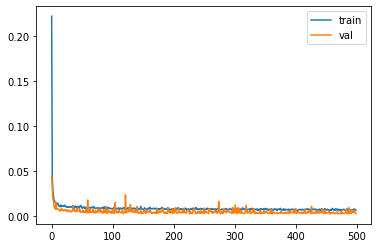

In [65]:
# plot loss curve
print('min train loss', min(train_loss), 'min val loss', min(val_loss))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

### Recursively predicting the next frame

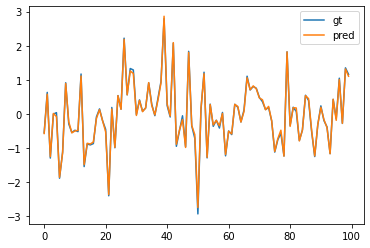

In [66]:
# test
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]
model.eval()
with torch.no_grad():
    test_out = model(xTest).detach().cpu().numpy().squeeze()

# plt.plot(yTest[:100].detach().cpu().numpy(), label='gt')
plt.plot(yTest[:,0:1][:100].detach().cpu().numpy(), label='gt')
plt.plot(test_out[:100], label='pred')
# plt.plot(xTest[:,0,-1][:100].detach().cpu().numpy().squeeze(), label='last input value')
plt.legend()

torch.Size([1757, 10]) torch.Size([1757, 10])
mape: 0.0352286659181118 cc 0.437923121591319


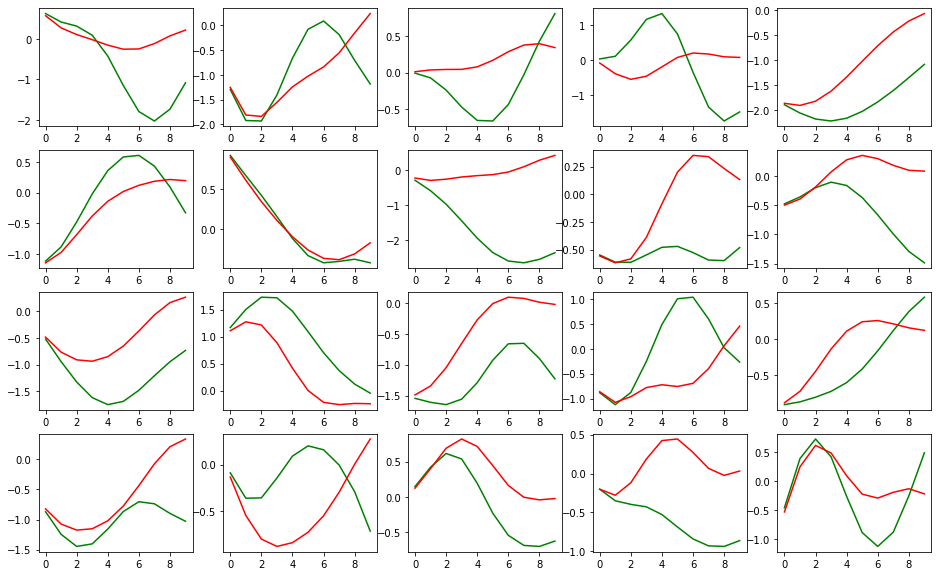

In [67]:
cur_in = xTest
pred = []

with torch.no_grad():
    for i in range(10):
        cur_out = model(cur_in)
        pred.append(cur_out)
        cur_in = torch.cat((cur_in, cur_out), 2)[:,:,1:]

pred = torch.cat(pred, 2).squeeze()
print(pred.shape, yTest.shape)
print('mape:', util.masked_mape(pred, yTest,0).item(), 'cc', util.get_cc(pred, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k].detach().cpu().numpy(), color='g')
        plt.plot(pred[k].detach().cpu().numpy(), color='r')
plt.show()

### observations
predict near future converges immediately, but predicting further-away frames need much more epochs

### Directly mapping / predicting t frames

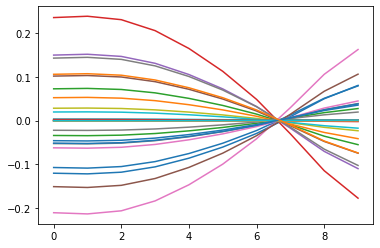

torch.Size([1757, 10]) torch.Size([1757, 10])
mape: 0.06740105897188187 cc 0.6453771691208389


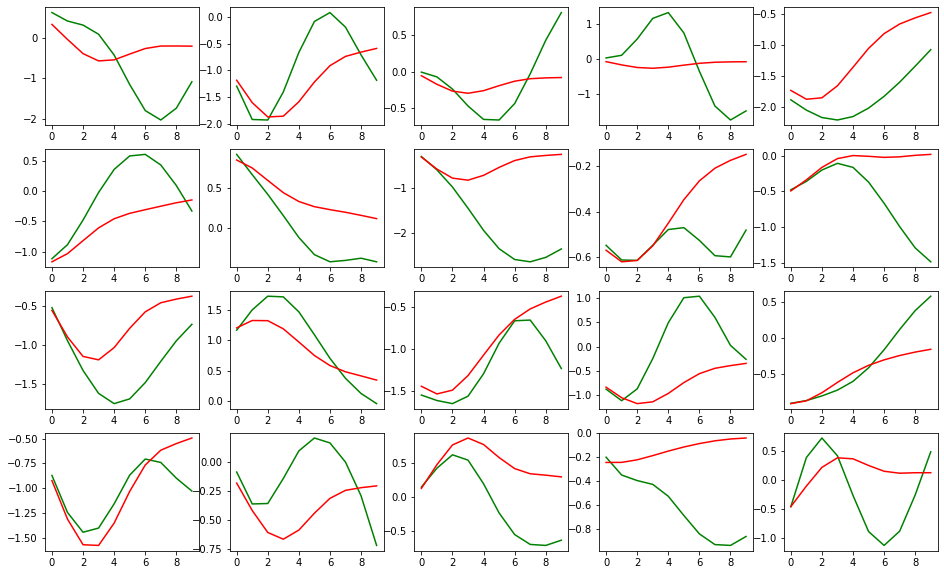

In [57]:
# test
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]

model.eval()
with torch.no_grad():
    test_out = model(xTest, viz=True).squeeze()

print(yTest.shape, test_out.shape)
print('mape:', util.masked_mape(test_out, yTest,0).item(), 'cc', util.get_cc(test_out, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k].detach().cpu().numpy(), color='g')
        plt.plot(test_out[k].detach().cpu().numpy(), color='r')
plt.show()

### Observations
Mapping is good.

prediction tend to converge to 0 --> this seems to happen to ARIMA as well (when predicting mean-stationary signals)

### t branches, each predict one future step. 
Also more weight on recent pred (otherwise further-away loss is dominating)

(Give up, since for the real problem EEG has so many frames, this isn't quite practical)